# Model Notebook
Feature Engineering:
 - Datetime extraction
 - Introduce Phases
 - Use predicted average daily temperature to help fit model.

I have decided to implement 3 different models. The model that returns the best average(weighted) of mean percentage errors(per crossing) will get to predict the future.
1. SARIMAX
2. FBProphet
3. LightGBM

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import holidays

# For SARIMAX
from tqdm import tqdm
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# For FBProphet
from fbprophet import Prophet

# For LightGBM
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import optuna

### Data Preprocessing
The original dataset can be found from data.ny.gov and time ranges from 2010-2020. <br>
https://data.ny.gov/Transportation/Hourly-Traffic-on-Metropolitan-Transportation-Auth/qzve-kjga <br>
The counts are in hourly form and need to be resampled to Daily.
In addition, the bridges('plaza_id') are coded numerically and need to be renamed. <br>
Please note: I have combined Triboro Manhattan and Triboro Bronx into Triboro.

On 2017, NYC finished installing cashless tolls. I will, therefore, use data from 2018 and on because data was collected differently prior to 2017.

In [4]:
df = return_series('mta.csv')


### 9 Toll Bridges in NYC

There are some days when there were 0 crossings over bridges. (missing values). <br> For this project, I have decided to fill the missing values with the previous day count. <br>





In [8]:

_df = df['2018':].copy()
for i in _df.columns:
    _df[i] = _df[i].replace(to_replace=0, method='ffill')

In [9]:
_df

plaza_id   Brooklyn Battery        Cross Bay        Henry Hudson         \
variable               cash ezpass      cash ezpass         cash ezpass   
datetime                                                                  
2018-01-01             3527  25636      1876  11829         5523  41017   
2018-01-02             4099  43061      2336  19539         5983  54627   
2018-01-03             4326  49679      2593  22014         6113  61870   
2018-01-04             1552  18932      1092   7211         1519  12983   
2018-01-05             3103  34904      1900  14939         4700  45150   
...                     ...    ...       ...    ...          ...    ...   
2020-10-06             7093  48860      3385  18802         7695  52157   
2020-10-07             7090  48514      3227  18876         8126  53803   
2020-10-08             7313  49405      3313  19392         8370  55294   
2020-10-09             7540  46132      3402  19839        10035  60207   
2020-10-10             6316  34818      3177  16757        10105  51852   

plaza_id   Marine Parkway        Queens Midtown        Throgs Neck          \
variable             cash ezpass           cash ezpass        cash  ezpass   
datetime                                                                     
2018-01-01           1096  11022           7338  47569       16177   82169   
2018-01-02           1517  18370           6554  60446       12971   93293   
2018-01-03           1635  20432           7071  64654       13045  102907   
2018-01-04            571   5596           2687  23938        3518   24888   
2018-01-05           1102  12827           5465  49688        9585   70892   
...                   ...    ...            ...    ...         ...     ...   
2020-10-06           2518  18667          10831  52764       14178   83961   
2020-10-07           2476  17918          11425  56360       14752   86849   
2020-10-08           2559  18748          11800  58204       15760   90958   
2020-10-09           2531  17999          13433  61760       17321   95125   
2020-10-10           2605  16447          12107  48178       19018   91976   

plaza_id   Triboro         Verrazano        Whitestone          
variable      cash  ezpass      cash ezpass       cash  ezpass  
datetime                                                        
2018-01-01   22395  118380     11583  70340      18818   90468  
2018-01-02   20751  144179      9319  86330      14843  102368  
2018-01-03   21182  153968      9110  94396      15263  108711  
2018-01-04    7787   56350      3319  34501       4855   33259  
2018-01-05   16429  118824      6841  67534      11586   79643  
...            ...     ...       ...    ...        ...     ...  
2020-10-06   26219  130693     11193  86130      20675  101180  
2020-10-07   26443  134036     11166  86913      20208   99960  
2020-10-08   28160  140175     11907  88834      21469  104514  
2020-10-09   30816  142961     13464  93085      25545  119287  
2020-10-10   32227  132258     14218  85350      26894  111136  

[1014 rows x 18 columns]

### Feature Engineering: Holidays
Holidays will be an important feature in determining daily toll traffic. I created a list of all the holidays from 2018-2021.

In [10]:
holidays_2018_2020 = []
for year in [2018, 2019, 2020, 2021]:
    for date in holidays.UnitedStates(years=year).items():
        holidays_2018_2020.append(date[0])
        
crossing_rates = {('Brooklyn Battery', 'cash'):9.50,
                 ('Brooklyn Battery', 'ezpass'):6.12,
                 ('Cross Bay', 'cash'):4.75,
                 ('Cross Bay', 'ezpass'):2.29,
                 ('Henry Hudson','cash'):7.00,
                 ('Henry Hudson','ezpass'):2.80,
                 ('Marine Parkway','cash'):4.75,
                 ('Marine Parkway','ezpass'):2.29,
                 ('Queens Midtown','cash'):9.50,
                 ('Queens Midtown','ezpass'):6.12,
                 ('Throgs Neck','cash'): 9.50,
                 ('Throgs Neck','ezpass'): 6.12,
                 ('Triboro','cash'): 9.50,
                 ('Triboro','ezpass'):6.12,
                 ('Verrazano','cash'):19.00,
                 ('Verrazano','ezpass'):12.24,
                 ('Whitestone','cash'):9.50,
                 ('Whitestone','ezpass'):6.12}

In [11]:
_df.columns

MultiIndex([('Brooklyn Battery',   'cash'),
            ('Brooklyn Battery', 'ezpass'),
            (       'Cross Bay',   'cash'),
            (       'Cross Bay', 'ezpass'),
            (    'Henry Hudson',   'cash'),
            (    'Henry Hudson', 'ezpass'),
            (  'Marine Parkway',   'cash'),
            (  'Marine Parkway', 'ezpass'),
            (  'Queens Midtown',   'cash'),
            (  'Queens Midtown', 'ezpass'),
            (     'Throgs Neck',   'cash'),
            (     'Throgs Neck', 'ezpass'),
            (         'Triboro',   'cash'),
            (         'Triboro', 'ezpass'),
            (       'Verrazano',   'cash'),
            (       'Verrazano', 'ezpass'),
            (      'Whitestone',   'cash'),
            (      'Whitestone', 'ezpass')],
           names=['plaza_id', 'variable'])

### Feature Engineering: Date Features
From datetime, I extract the month, day of the week, year, weekend... etc. <br> In addition, I have included the 8 events that occurred in **2020**
0. March 12 - Events with more than 500 people cancelled
1. March 22 - NYS Pause Program begins, all non-essential workers must stay home
2. April 16 - Governor Cuomo extendes the stay-at-home order and school closures to May 15
3. May 15 - Governor Cuomo extends PAUSE to May 28
4. June 8 - NYC begins Phase 1 opening
5. June 22 - NYC begins Phase 2 opening
6. July 7 - NYC begins Phase 3 opening
7. July 19 - NYC begins Phase 4 opening

The timeline was extracted from investopedia. <br>
https://www.investopedia.com/historical-timeline-of-covid-19-in-new-york-city-5071986

In [12]:
def date_features(_df):
    _df['month'] = _df.index.month
    _df['dayofweek'] = _df.index.dayofweek
    _df['year'] = _df.index.year
    _df['week'] = _df.index.isocalendar().week
    _df['day'] = _df.index.day
    _df['quarter'] = _df.index.quarter
    _df['dayofyear'] = _df.index.dayofyear


    conditions = [
        (_df.index >= '2020-03-12') & (_df.index < '2020-03-22'),
        (_df.index >= '2020-03-22') & (_df.index < '2020-04-16'),
        (_df.index >= '2020-04-16') & (_df.index < '2020-05-15'),
        (_df.index >= '2020-05-15') & (_df.index < '2020-06-08'),
        (_df.index >= '2020-06-08') & (_df.index < '2020-06-22'),
        (_df.index >= '2020-06-22') & (_df.index < '2020-07-06'),
        (_df.index >= '2020-07-06') & (_df.index < '2020-07-19'),
        (_df.index >= '2020-07-19')
    ]

    choices = [
        0,
        1,
        2,
        3,
        4,
        5,
        6,
        7,
    ]

    _df['Phase'] = np.select(conditions, choices, -1)
    
    _df['weekend'] = (_df.index.dayofweek>4).astype(int)
    _df['holiday'] = np.where(_df.index.isin(holidays_2018_2020), 1, 0)
    return _df



In [13]:
_df = date_features(_df)
print(_df.shape)
_df.head()

(1014, 28)


plaza_id   Brooklyn Battery        Cross Bay        Henry Hudson         \
variable               cash ezpass      cash ezpass         cash ezpass   
datetime                                                                  
2018-01-01             3527  25636      1876  11829         5523  41017   
2018-01-02             4099  43061      2336  19539         5983  54627   
2018-01-03             4326  49679      2593  22014         6113  61870   
2018-01-04             1552  18932      1092   7211         1519  12983   
2018-01-05             3103  34904      1900  14939         4700  45150   

plaza_id   Marine Parkway        Queens Midtown         ... month dayofweek  \
variable             cash ezpass           cash ezpass  ...                   
datetime                                                ...                   
2018-01-01           1096  11022           7338  47569  ...     1         0   
2018-01-02           1517  18370           6554  60446  ...     1         1   
2018-01-03           1635  20432           7071  64654  ...     1         2   
2018-01-04            571   5596           2687  23938  ...     1         3   
2018-01-05           1102  12827           5465  49688  ...     1         4   

plaza_id    year week day quarter dayofyear Phase weekend holiday  
variable                                                           
datetime                                                           
2018-01-01  2018    1   1       1         1    -1       0       1  
2018-01-02  2018    1   2       1         2    -1       0       0  
2018-01-03  2018    1   3       1         3    -1       0       0  
2018-01-04  2018    1   4       1         4    -1       0       0  
2018-01-05  2018    1   5       1         5    -1       0       0  

[5 rows x 28 columns]

### Feature Engineer: Average Daily Temperatures
I will predict the average daily temperature from 2018 to current and use the y_hat values as a feature. The temperature data will train from 2010 to 2018.

The dataset comes from https://w2.weather.gov/climate/xmacis.php?wfo=okx with JFK, NY selected.
It ranges from 2010-2020. I will be only taking temp_average of each day.
The dataset will be made applicable via kaggle.


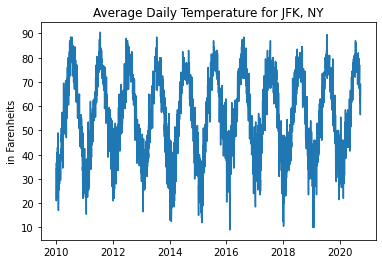

In [14]:
temperature = pd.read_csv('weather.csv', sep ='\t', engine ='python')
temperature['datetime'] = pd.to_datetime(temperature['datetime'])
plt.plot(temperature['datetime'], temperature['temp_average'])
plt.title('Average Daily Temperature for JFK, NY');
plt.ylabel('in Farenheits');

I'll do a quick forecasting on average daily temperature using FBProphet. <br>
Training set was 2010-2017, Testing set: 2018-2020

In [15]:
_temperature = date_features(temperature.set_index('datetime')[['temp_average']])
_fb_weather = _temperature.reset_index()[['datetime', 'temp_average']]
_fb_weather.columns = ['ds', 'y']
_fb_weather.head()

,ds,y
0,2010-01-01,36.5
1,2010-01-02,25.0
2,2010-01-03,21.0
3,2010-01-04,26.0
4,2010-01-05,26.5


In [16]:
m = Prophet(
           changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 300,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
m.fit(_fb_weather)

In [17]:
future = m.make_future_dataframe(periods = 365*2)
forecast = m.predict(future)

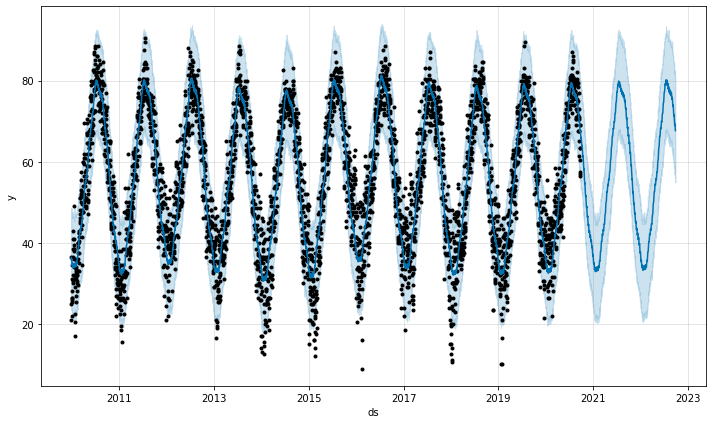

In [18]:
fig1 = m.plot(forecast)

In [19]:
sliced_forecast = forecast.loc[forecast['ds'].isin(pd.date_range(start='2018-01-01', end='2020-10-10'))]
sliced_forecast.reset_index(drop=True, inplace=True)

In [20]:
sliced_forecast = sliced_forecast[['ds', 'yhat']]
sliced_forecast.columns = ['datetime', 'temp_average']
sliced_forecast.set_index('datetime', inplace=True)
sliced_forecast.head()

,temp_average
datetime,
2018-01-01,34.744700
2018-01-02,35.134029
2018-01-03,34.775099
2018-01-04,34.159110
2018-01-05,33.598794


In [21]:
_df['temp_average'] = sliced_forecast['temp_average']

In [22]:
_df

plaza_id   Brooklyn Battery        Cross Bay        Henry Hudson         \
variable               cash ezpass      cash ezpass         cash ezpass   
datetime                                                                  
2018-01-01             3527  25636      1876  11829         5523  41017   
2018-01-02             4099  43061      2336  19539         5983  54627   
2018-01-03             4326  49679      2593  22014         6113  61870   
2018-01-04             1552  18932      1092   7211         1519  12983   
2018-01-05             3103  34904      1900  14939         4700  45150   
...                     ...    ...       ...    ...          ...    ...   
2020-10-06             7093  48860      3385  18802         7695  52157   
2020-10-07             7090  48514      3227  18876         8126  53803   
2020-10-08             7313  49405      3313  19392         8370  55294   
2020-10-09             7540  46132      3402  19839        10035  60207   
2020-10-10             6316  34818      3177  16757        10105  51852   

plaza_id   Marine Parkway        Queens Midtown         ... dayofweek  year  \
variable             cash ezpass           cash ezpass  ...                   
datetime                                                ...                   
2018-01-01           1096  11022           7338  47569  ...         0  2018   
2018-01-02           1517  18370           6554  60446  ...         1  2018   
2018-01-03           1635  20432           7071  64654  ...         2  2018   
2018-01-04            571   5596           2687  23938  ...         3  2018   
2018-01-05           1102  12827           5465  49688  ...         4  2018   
...                   ...    ...            ...    ...  ...       ...   ...   
2020-10-06           2518  18667          10831  52764  ...         1  2020   
2020-10-07           2476  17918          11425  56360  ...         2  2020   
2020-10-08           2559  18748          11800  58204  ...         3  2020   
2020-10-09           2531  17999          13433  61760  ...         4  2020   
2020-10-10           2605  16447          12107  48178  ...         5  2020   

plaza_id   week day quarter dayofyear Phase weekend holiday temp_average  
variable                                                                  
datetime                                                                  
2018-01-01    1   1       1         1    -1       0       1    34.744700  
2018-01-02    1   2       1         2    -1       0       0    35.134029  
2018-01-03    1   3       1         3    -1       0       0    34.775099  
2018-01-04    1   4       1         4    -1       0       0    34.159110  
2018-01-05    1   5       1         5    -1       0       0    33.598794  
...         ...  ..     ...       ...   ...     ...     ...          ...  
2020-10-06   41   6       4       280     7       0       0    64.022413  
2020-10-07   41   7       4       281     7       0       0    63.618630  
2020-10-08   41   8       4       282     7       0       0    62.928621  
2020-10-09   41   9       4       283     7       0       0    62.261273  
2020-10-10   41  10       4       284     7       1       0    61.682719  

[1014 rows x 29 columns]

## Models

### Dummy Regressor
My baseline will be the average of the last 7 days for each bridge.
The sum of the 9 rmse (for each bridge) will be my metric.
I have chosen to use root mean squared error because it is more sensitive to larger errors than MAE(mean absolute error) or MAPE(mean absolute percentage error)

In [23]:
tr_start,tr_end = '2018-01-01','2020-09-05'
te_start,te_end = '2020-09-06','2020-10-10'
_total_dollars = 0
_total_dollar_values = []
for crossing,rate in crossing_rates.items():
    _total_dollars += _df[te_start:te_end][crossing].sum() * rate
    _total_dollar_values.append(_df[te_start:te_end][crossing].sum() * rate)

    
print('Total Revenue from 09-06-2020 to 10-10-2020: ',_total_dollars)

Total Revenue from 09-06-2020 to 10-10-2020:  173780402.32


In [34]:
def mean_percentage_error(actual, yhat):
    """
    actual, yhat: list or numpy array
    length of listlike arrays must be same
    
    returns the mean percentage error
    """
    # converting list to array
    if type(actual) == 'list':
        actual = np.array(actual)
    if type(yhat) == 'list':
        yhat = np.array(yhat)
        
        
    _mean = (actual - yhat)/actual
    
    return _mean.sum()/len(_mean)
    
    

In [31]:
a1 = [1,2,3,4,5]
b1 = [1,2,5,3,4]
_a1_array = np.array(a1)
_b1_array = np.array(b1)

In [32]:
_mean = (_a1_array - _b1_array)/_a1_array
_mean.sum()/len(_mean)

-0.04333333333333332

In [33]:
type(a1)

list

In [35]:
mean_percentage_error(_a1_array, _b1_array)

-0.04333333333333332

In [46]:
tr_start,tr_end = '2018-01-01','2020-09-05'
te_start,te_end = '2020-09-06','2020-10-10'
_total_dollars = 0
_total_dollar_values = []
for crossing,rate in crossing_rates.items():
    _total_dollars += _df[te_start:te_end][crossing].sum() * rate
    _total_dollar_values.append(_df[te_start:te_end][crossing].sum() * rate)

    
print('Total Revenue from 09-06-2020 to 10-10-2020: ',_total_dollars)

Total Revenue from 09-06-2020 to 10-10-2020:  173780402.32


In [36]:
_results_df = pd.DataFrame()
_results_df['bridges'] = list(crossing_rates.keys())
# _results_df['dummy_MA7'] = dummy_MA7
_results_df['Actual_Dollars'] = _total_dollar_values
_results_df

,bridges,Actual_Dollars
0,"(Brooklyn Battery, cash)",2281852.50
1,"(Brooklyn Battery, ezpass)",9145011.96
2,"(Cross Bay, cash)",553769.25
3,"(Cross Bay, ezpass)",1491600.66
4,"(Henry Hudson, cash)",2100210.00
5,"(Henry Hudson, ezpass)",5092189.20
6,"(Marine Parkway, cash)",464018.00
7,"(Marine Parkway, ezpass)",1495395.19
8,"(Queens Midtown, cash)",3810678.00
9,"(Queens Midtown, ezpass)",11176191.00


In [46]:
tr_start,tr_end = '2018-01-01','2020-09-05'
te_start,te_end = '2020-09-06','2020-10-10'


dummy_MA7 = []
_dummy_dollars = 0
for crossing,rate in crossing_rates.items():
    tes = _df[te_start:te_end][crossing]
    tra = _df[tr_start:tr_end][crossing]
    _dummy = pd.DataFrame()
    _dummy['datetime'] = pd.date_range(start='2020-09-06', end='2020-10-10')
    _dummy.set_index('datetime', inplace=True)
    _dummy[crossing] = tra.tail(7).mean()
    
    
    
    
    dummy_MA7.append(mean_percentage_error(tes, _dummy[crossing]))
#     _dummy_dollars += _dummy[crossing].sum() * rate

# print('Error on Dollars forecast(test) for Dummy: ', _dummy_dollars - _total_dollars)

In [47]:
_results_df['Dummy_Avg7'] = dummy_MA7
_results_df.sum(axis=0)

bridges           Brooklyn Battery
Actual_Dollars          1.7378e+08
Dummy_Avg7                -1.60936
dtype: object

In [49]:
_results_df

,bridges,Actual_Dollars,Dummy_Avg7
0,"(Brooklyn Battery, cash)",2281852.50,-0.057684
1,"(Brooklyn Battery, ezpass)",9145011.96,-0.066757
2,"(Cross Bay, cash)",553769.25,-0.219075
3,"(Cross Bay, ezpass)",1491600.66,-0.134245
4,"(Henry Hudson, cash)",2100210.00,-0.047837
5,"(Henry Hudson, ezpass)",5092189.20,-0.004591
6,"(Marine Parkway, cash)",464018.00,-0.418440
7,"(Marine Parkway, ezpass)",1495395.19,-0.224168
8,"(Queens Midtown, cash)",3810678.00,-0.034336
9,"(Queens Midtown, ezpass)",11176191.00,-0.016810


In [50]:
_results_df.mean(axis=0)

Actual_Dollars    9.654467e+06
Dummy_Avg7       -8.940915e-02
dtype: float64

### SARIMAX
I will use the features created from above as my independent exogenous variables. <br>
the values (p,d,q)x(P,D,Q,m), and trend was found through grid searching. <br>

I have used m=7 because the data points are daily.

### One Hot Encoder
After all features have been created, I will need to dummify the categorical features for SARIMAX.

In [51]:
ohe = OneHotEncoder(drop='first')
categorical_columns = ['month', 'dayofweek', 'quarter', 'Phase']
_df_ohe = ohe.fit_transform(_df[categorical_columns]).toarray()
_df_ohe_df = pd.DataFrame(data = _df_ohe,
                           index = _df.index,
                          columns = ohe.get_feature_names(categorical_columns))

_df_merged = _df.merge(_df_ohe_df, left_index=True, right_index=True)
_df_ohe_df['weekend'] = _df['weekend']
_df_ohe_df['holiday'] = _df['holiday']
_df_ohe_df['temp_average'] = _df['temp_average']
_df_ohe_df.shape

C:\Users\albert\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning:

merging between different levels can give an unintended result (2 levels on the left,1 on the right)



(1014, 31)

In [52]:
_df_merged.columns

Index([  ('Brooklyn Battery', 'cash'), ('Brooklyn Battery', 'ezpass'),
                ('Cross Bay', 'cash'),        ('Cross Bay', 'ezpass'),
             ('Henry Hudson', 'cash'),     ('Henry Hudson', 'ezpass'),
           ('Marine Parkway', 'cash'),   ('Marine Parkway', 'ezpass'),
           ('Queens Midtown', 'cash'),   ('Queens Midtown', 'ezpass'),
              ('Throgs Neck', 'cash'),      ('Throgs Neck', 'ezpass'),
                  ('Triboro', 'cash'),          ('Triboro', 'ezpass'),
                ('Verrazano', 'cash'),        ('Verrazano', 'ezpass'),
               ('Whitestone', 'cash'),       ('Whitestone', 'ezpass'),
                        ('month', ''),              ('dayofweek', ''),
                         ('year', ''),                   ('week', ''),
                          ('day', ''),                ('quarter', ''),
                    ('dayofyear', ''),                  ('Phase', ''),
                      ('weekend', ''),                ('holiday', ''),
      

In [53]:
_df_merged.rename(columns = {('month', ''):'month', ('year', ''):'year', ('day', ''):'day', ('dayofyear', ''): 'dayofyear', 
                             ('weekend', ''):'weekend', ('temp_average', ''):'temp_average', ('dayofweek', ''):'dayofweek',
                            ('week', ''):'week', ('quarter', ''):'quarter', ('Phase', ''):'Phase', ('holiday', ''):'holiday'}, inplace=True)

In [54]:
def return_sarimax_dollars(bridge, rate, _order, _seasonal_order, _trend):
    """
    returns arima rmse
    """
    tr_start,tr_end = '2018-01-01','2020-09-05'
    te_start,te_end = '2020-09-06','2020-10-10'
    tra = _df_merged[tr_start:tr_end][bridge]
    tes = _df_merged[te_start:te_end][bridge]
    exog_train = _df_ohe_df[tr_start:tr_end]
    exog_test = _df_ohe_df[te_start:te_end]
    
    model_SARIMAX = SARIMAX(tra, order=_order, seasonal_order= _seasonal_order, exog = exog_train, trend = _trend,
                        freq='D', enforce_stationarity=False, enforce_invertibility=False)
    results = model_SARIMAX.fit(maxiter=1000)
    
    pred = results.predict(te_start,te_end, exog = exog_test)

    
    _mpe = mean_percentage_error(tes, pred)
    
    return _mpe

### Grid Search
I took this technique from machine learning mastery. It brute forces the combinations. <br>
I have set m = 7 because this is daily data. <br>
The selected params were (1,1,2)x(1,0,1,7) trend='n'


In [96]:
# code was taken from machine learning mastery
models = list()
p_params = [0, 1, 2]
d_params = [0, 1]
q_params = [0, 1, 2]
t_params = ['n','c','t','ct']
P_params = [0, 1, 2]
D_params = [0, 1]
Q_params = [0, 1, 2]
m_params = [7]
# create config instances
for p in p_params:
    for d in d_params:
        for q in q_params:
            for t in t_params:
                for P in P_params:
                    for D in D_params:
                        for Q in Q_params:
                            for m in m_params:
                                cfg = [(p,d,q), (P,D,Q,m), t]
                                models.append(cfg)


In [97]:
# # This grid search took around 40 hours. Please don't run this.
# _grid_sarimax = []
# for model in tqdm(models):
#     _each_grid = []
#     for i in bridges:
#         _each_grid.append(return_sarimax_rmse(i, model[0], model[1], model[2]))
#     print((sum(l7), model))
#     _grid_sarimax.append((sum(l7), model))

In [55]:
# Please note, I fit a sarimax model for each of the 9 bridges and returned an rmse from the test set.
# I should have 9 rmse (one for each bridge), the summation of the rmse will be the final metric.


    
_sarimax_dollar_values = []
_sarimax_dollars = 0
for crossing,rate in tqdm(crossing_rates.items()):
    _bridge_dollar = return_sarimax_dollars(crossing, rate, (1,1,2), (1,0,1,7), 'n')
    _sarimax_dollars += _bridge_dollar
    _sarimax_dollar_values.append(_bridge_dollar)

100%|██████████| 18/18 [03:03<00:00, 10.20s/it]


In [56]:
print('Error on Dollars forecast(test) for SARMIAX: ',_sarimax_dollars - _total_dollars)

Error on Dollars forecast(test) for SARMIAX:  -173780402.99757555


In [57]:
_results_df['SARIMAX'] = _sarimax_dollar_values
_results_df

,bridges,Actual_Dollars,Dummy_Avg7,SARIMAX
0,"(Brooklyn Battery, cash)",2281852.50,-0.057684,-0.013255
1,"(Brooklyn Battery, ezpass)",9145011.96,-0.066757,-0.023781
2,"(Cross Bay, cash)",553769.25,-0.219075,-0.134317
3,"(Cross Bay, ezpass)",1491600.66,-0.134245,-0.067424
4,"(Henry Hudson, cash)",2100210.00,-0.047837,-0.011267
5,"(Henry Hudson, ezpass)",5092189.20,-0.004591,0.034878
6,"(Marine Parkway, cash)",464018.00,-0.418440,-0.331336
7,"(Marine Parkway, ezpass)",1495395.19,-0.224168,-0.136274
8,"(Queens Midtown, cash)",3810678.00,-0.034336,0.024303
9,"(Queens Midtown, ezpass)",11176191.00,-0.016810,0.032379


In [58]:
_results_df.mean(axis=0)

Actual_Dollars    9.654467e+06
Dummy_Avg7       -8.940915e-02
SARIMAX          -3.764309e-02
dtype: float64

### FBProphet
After implement SARIMAX, I will now move on to FBProphet. <br>
Please note, the FBProphet was not hyperturned

In [59]:
_df_merged.columns

Index([  ('Brooklyn Battery', 'cash'), ('Brooklyn Battery', 'ezpass'),
                ('Cross Bay', 'cash'),        ('Cross Bay', 'ezpass'),
             ('Henry Hudson', 'cash'),     ('Henry Hudson', 'ezpass'),
           ('Marine Parkway', 'cash'),   ('Marine Parkway', 'ezpass'),
           ('Queens Midtown', 'cash'),   ('Queens Midtown', 'ezpass'),
              ('Throgs Neck', 'cash'),      ('Throgs Neck', 'ezpass'),
                  ('Triboro', 'cash'),          ('Triboro', 'ezpass'),
                ('Verrazano', 'cash'),        ('Verrazano', 'ezpass'),
               ('Whitestone', 'cash'),       ('Whitestone', 'ezpass'),
                              'month',                    'dayofweek',
                               'year',                         'week',
                                'day',                      'quarter',
                          'dayofyear',                        'Phase',
                            'weekend',                      'holiday',
      

In [67]:
tes = _df_merged[te_start:te_end][('Brooklyn Battery', 'cash')]

In [69]:
tes.values

array([6117, 5096, 7067, 7299, 7001, 8412, 6373, 5622, 7039, 7059, 7144,
       7414, 7892, 6688, 5145, 6883, 7137, 7354, 7553, 8190, 6756, 5292,
       5762, 6881, 7298, 7871, 7681, 7157, 4910, 6750, 7093, 7090, 7313,
       7540, 6316], dtype=int64)

In [70]:
def return_prophet_dollars(bridge, rate):
    tr_start,tr_end = '2018-01-01','2020-09-05'
    te_start,te_end = '2020-09-06','2020-10-10'
    tra = _df_merged[tr_start:tr_end][[bridge]]
    tes = _df_merged[te_start:te_end][bridge]

    _fb_exog = _df_merged[['month', 'dayofweek', 'quarter',
           'Phase', 'weekend', 'holiday', 'temp_average']]

    tra = tra.join(_fb_exog)



    exog_train = _df_ohe_df[tr_start:tr_end]

    tra = tra.reset_index()
    tra = tra.rename(columns = {bridge:'y', 'datetime': 'ds'})



    m = Prophet(
           changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 300,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
    for i in _fb_exog.columns:
        m.add_regressor(i)


    m.fit(tra)
    
    # Please change the periods after changing the te_start and te_end. For this case i have made periods 35 because there are 35 days on the the test set.
    future = m.make_future_dataframe(periods=35)
    future.set_index('ds', inplace=True)
    future = future.join(_fb_exog)
    future.reset_index(inplace=True)
    pred = m.predict(future[-35:])

    
    _mpe = mean_percentage_error(tes.values, pred['yhat'])
    
    return _mpe

In [71]:
_fbprophet_dollar_values = []

_fbprophet_dollars = 0
for crossing,rate in tqdm(crossing_rates.items()):
    _dollar_value = return_prophet_dollars(crossing, rate)
    _fbprophet_dollars += _dollar_value
    _fbprophet_dollar_values.append(_dollar_value)


100%|██████████| 18/18 [09:43<00:00, 32.44s/it]


In [72]:
_fbprophet_dollar_values

[0.006648354539932687,
 -0.032989236524954425,
 0.049410565440886255,
 0.02944639339093983,
 0.053382584360827684,
 -0.023421900259215735,
 -0.11678527871643402,
 0.08323458079671309,
 0.08728090697686784,
 0.08462639917451201,
 0.026946502196657236,
 -0.03609827336965267,
 0.007906823993336393,
 0.004238339984595171,
 0.003278085684468994,
 -0.030116515658124805,
 0.03464690099781207,
 -0.003914178084274629]

In [73]:
print('Error on Dollars forecast(test) for FBProphet: ',_fbprophet_dollars - _total_dollars)

Error on Dollars forecast(test) for FBProphet:  -173780402.09227893


In [74]:
_results_df['FBProphet'] = _fbprophet_dollar_values

In [75]:
_results_df

,bridges,Actual_Dollars,Dummy_Avg7,SARIMAX,FBProphet
0,"(Brooklyn Battery, cash)",2281852.50,-0.057684,-0.013255,0.006648
1,"(Brooklyn Battery, ezpass)",9145011.96,-0.066757,-0.023781,-0.032989
2,"(Cross Bay, cash)",553769.25,-0.219075,-0.134317,0.049411
3,"(Cross Bay, ezpass)",1491600.66,-0.134245,-0.067424,0.029446
4,"(Henry Hudson, cash)",2100210.00,-0.047837,-0.011267,0.053383
5,"(Henry Hudson, ezpass)",5092189.20,-0.004591,0.034878,-0.023422
6,"(Marine Parkway, cash)",464018.00,-0.418440,-0.331336,-0.116785
7,"(Marine Parkway, ezpass)",1495395.19,-0.224168,-0.136274,0.083235
8,"(Queens Midtown, cash)",3810678.00,-0.034336,0.024303,0.087281
9,"(Queens Midtown, ezpass)",11176191.00,-0.016810,0.032379,0.084626


In [77]:
_results_df.mean(axis=0)

Actual_Dollars    9.654467e+06
Dummy_Avg7       -8.940915e-02
SARIMAX          -3.764309e-02
FBProphet         1.265117e-02
dtype: float64

In [81]:
def weighted_average_mpe(array, actual_dollars):
    """
    array: np.array()
    returns a weighted average relative to actual dollars
    """
    _numerator = array * actual_dollars
    _denominator = actual_dollars.sum()
    
    return _numerator.sum()/_denominator
    

In [82]:
weighted_average_mpe(_results_df['Dummy_Avg7'], _results_df['Actual_Dollars'])

-0.040138394579303176

In [83]:
weighted_average_mpe(_results_df['SARIMAX'], _results_df['Actual_Dollars'])

0.0003546870163775394

In [84]:
weighted_average_mpe(_results_df['FBProphet'], _results_df['Actual_Dollars'])

-0.0006400259426094087

### LightGBM
After using tuned SARIMAX and a more-or-less generic FBProphet, I thought it was a good opportunity to try changing the time series problem into a decision tree regression problem. Instead of having 9 separate models for each bridge, we can have 1 GBDT model. This is done by first melting all the columns and making the dataframe long. As I have created features in the SARIMAX and FBProphet models, I will do the same here.

In [23]:
def return_series(csv_path):
    """
    
    """
    
    def parse(x):
        return datetime.datetime.strptime(x, '%m/%d/%Y %H')
    
    df = pd.read_csv(csv_path, parse_dates=[['Date','Hour']], date_parser=parse)
    df = df.loc[~df.duplicated()]
    df = df.loc[df['Date_Hour'] >= '2018'].copy(deep=True)
    
    conditions = [
    df['Plaza ID'].eq(21) | df['Plaza ID'].eq(1),
    df['Plaza ID'].eq(22) | df['Plaza ID'].eq(2),
    df['Plaza ID'].eq(23) | df['Plaza ID'].eq(3),
    df['Plaza ID'].eq(24) | df['Plaza ID'].eq(4),
    df['Plaza ID'].eq(25) | df['Plaza ID'].eq(5),
    df['Plaza ID'].eq(26) | df['Plaza ID'].eq(6),
    df['Plaza ID'].eq(27) | df['Plaza ID'].eq(7),
    df['Plaza ID'].eq(28) | df['Plaza ID'].eq(8),
    df['Plaza ID'].eq(29) | df['Plaza ID'].eq(9),
    df['Plaza ID'].eq(30) | df['Plaza ID'].eq(11)
    ]
    choices = [
        'Triboro',
        'Triboro',
        'Whitestone',
        'Henry Hudson',
        'Marine Parkway',
        'Cross Bay',
        'Queens Midtown',
        'Brooklyn Battery',
        'Throgs Neck',
        'Verrazano'
    ]
    df['plaza_id'] = np.select(conditions, choices, 0)
    
    df.drop(columns=['Plaza ID', 'Direction'], inplace=True)
    df.columns = ['datetime', 'ezpass', 'cash', 'plaza_id']
    _df = df.melt(id_vars=['datetime','plaza_id'], value_vars=['ezpass', 'cash'])
#     _df['crossing'] = _df['plaza_id'] + '_' + _df['variable']
    
#     _df.set_index('datetime', inplace=True)
#     _df = _df.groupby(['crossing'])['value'].resample('1D').sum()
#     _df = _df.unstack().T
    

    
    return _df


In [24]:
lgbm_df = return_series('mta.csv')

In [25]:
lgbm_df.set_index('datetime', inplace=True)

In [26]:
_ffill_lgbm = lgbm_df.groupby(['plaza_id', 'variable'])['value'].resample('1D').sum()

In [27]:
_ffill_lgbm = _ffill_lgbm.reset_index()

In [28]:
_ffill_lgbm = _ffill_lgbm.pivot(index='datetime', columns = ['plaza_id', 'variable'], values='value')

In [29]:
for i in crossing_rates.keys():
    _ffill_lgbm[i] = _ffill_lgbm[i].replace(to_replace=0, method='ffill')

In [30]:
_ffill_lgbm = _ffill_lgbm.unstack().reset_index()

In [31]:
_ffill_lgbm.rename(columns={0: 'value'}, inplace=True)

In [32]:
_ffill_lgbm.set_index('datetime', inplace=True)

In [33]:
_var = {'cash':0, 'ezpass': 1}
_ffill_lgbm['variable'] = [_var[item] for item in _ffill_lgbm['variable']]

In [34]:
_ffill_lgbm.isna().sum()

plaza_id    0
variable    0
value       0
dtype: int64

In [35]:
le = LabelEncoder()
_ffill_lgbm['plaza_id'] = le.fit_transform(_ffill_lgbm['plaza_id'])

In [36]:
_ffill_lgbm

,plaza_id,variable,value
datetime,,,
2018-01-01,0,0,3527
2018-01-02,0,0,4099
2018-01-03,0,0,4326
2018-01-04,0,0,1552
2018-01-05,0,0,3103
...,...,...,...
2020-10-06,8,1,101180
2020-10-07,8,1,99960
2020-10-08,8,1,104514


In [37]:
_ffill_lgbm = date_features(_ffill_lgbm)

_ffill_lgbm = _ffill_lgbm.join(sliced_forecast)
# There are many instances where I'll set an index to datetime and reset it.
# This is my fault for not making the data preprocessing functions take the same columns. For example: date_features takes index, while date_lag takes the column
_ffill_lgbm.reset_index(inplace=True)

In [38]:
_ffill_lgbm.rename(columns={'plaza_id':'crossing'}, inplace=True)

In [54]:
# Creating 3 sliced dataframes
train_set = _ffill_lgbm.loc[_ffill_lgbm['datetime'] <= '2020-09-05'].copy(deep=True)
test_set = _ffill_lgbm.loc[(_ffill_lgbm['datetime'] > '2020-09-05') & (_ffill_lgbm['datetime'] <= '2020-10-10')].copy(deep=True)
pred_set = _ffill_lgbm.loc[(_ffill_lgbm['datetime'] > '2020-09-05')].copy(deep=True)
pred_set['value'] = np.nan
pred_set.tail()

,datetime,crossing,variable,value,month,dayofweek,year,week,day,quarter,dayofyear,Phase,weekend,holiday,temp_average
18247,2020-10-10,6,1,NaN,10,5,2020,41,10,4,284,7,1,0,61.682719
18248,2020-10-10,7,0,NaN,10,5,2020,41,10,4,284,7,1,0,61.682719
18249,2020-10-10,7,1,NaN,10,5,2020,41,10,4,284,7,1,0,61.682719
18250,2020-10-10,8,0,NaN,10,5,2020,41,10,4,284,7,1,0,61.682719
18251,2020-10-10,8,1,NaN,10,5,2020,41,10,4,284,7,1,0,61.682719


In [55]:
train_set

,datetime,crossing,variable,value,month,dayofweek,year,week,day,quarter,dayofyear,Phase,weekend,holiday,temp_average
0,2018-01-01,0,0,3527,1,0,2018,1,1,1,1,-1,0,1,34.744700
1,2018-01-01,0,1,25636,1,0,2018,1,1,1,1,-1,0,1,34.744700
2,2018-01-01,1,0,1876,1,0,2018,1,1,1,1,-1,0,1,34.744700
3,2018-01-01,1,1,11829,1,0,2018,1,1,1,1,-1,0,1,34.744700
4,2018-01-01,2,0,5523,1,0,2018,1,1,1,1,-1,0,1,34.744700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17617,2020-09-05,6,1,121053,9,5,2020,36,5,3,249,7,1,0,72.496286
17618,2020-09-05,7,0,14508,9,5,2020,36,5,3,249,7,1,0,72.496286
17619,2020-09-05,7,1,82759,9,5,2020,36,5,3,249,7,1,0,72.496286
17620,2020-09-05,8,0,26880,9,5,2020,36,5,3,249,7,1,0,72.496286


In [56]:
def date_lags(_df):
    """
    creates lag 7 and lag 28 features from values.
    creates ma7_lag7, ma7_lag28, ma28_lag7, ma28_lag28.
    
    """
    
#     _df['lag_1'] = _df[['crossing', 'variable','value']].groupby(['crossing', 'variable'])['value'].shift(1)
#     _df['lag_2'] = _df[['crossing', 'variable','value']].groupby(['crossing', 'variable'])['value'].shift(2)
    
#     _df['mean_lag1_roll7'] = _df[['crossing', 'variable','value', 'lag_1']].groupby(['crossing', 'variable'])['lag_1'].apply(lambda x: x.rolling(7).mean())
#     _df['mean_lag1_roll3'] = _df[['crossing', 'variable','value', 'lag_1']].groupby(['crossing', 'variable'])['lag_1'].apply(lambda x: x.rolling(3).mean())
#     _df['diff_7'] = _df[['crossing', 'variable','value']].groupby(['crossing', 'variable'])['value'].diff(7)
    
    _df['lag_7'] = _df[['crossing', 'variable','value']].groupby(['crossing', 'variable'])['value'].shift(7)
    _df['lag_14'] = _df[['crossing', 'variable','value']].groupby(['crossing', 'variable'])['value'].shift(14)
    _df['lag_21'] = _df[['crossing', 'variable','value']].groupby(['crossing', 'variable'])['value'].shift(21)
    _df['lag_28'] = _df[['crossing', 'variable','value']].groupby(['crossing', 'variable'])['value'].shift(28)
#     _df['lag_35'] = _df[['crossing', 'value']].groupby('crossing')['value'].shift(35)

    
    
    _df['mean_lag7_roll7'] = _df[['crossing', 'variable','value', 'lag_7']].groupby(['crossing', 'variable'])['lag_7'].apply(lambda x: x.rolling(7).mean())
    _df['mean_lag7_roll28'] = _df[['crossing', 'variable','value', 'lag_7']].groupby(['crossing', 'variable'])['lag_7'].apply(lambda x: x.rolling(28).mean())
    _df['mean_lag28_roll7'] = _df[['crossing', 'variable','value', 'lag_28']].groupby(['crossing', 'variable'])['lag_28'].apply(lambda x: x.rolling(7).mean())
    _df['mean_lag28_roll28'] = _df[['crossing', 'variable','value', 'lag_28']].groupby(['crossing', 'variable'])['lag_28'].apply(lambda x: x.rolling(28).mean())
    _df['week'] = _df['week'].astype('int64')
    
    return _df

In [57]:
train_set = date_lags(train_set)
train_set.tail()

,datetime,crossing,variable,value,month,dayofweek,year,week,day,quarter,...,holiday,temp_average,lag_7,lag_14,lag_21,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
17617,2020-09-05,6,1,121053,9,5,2020,36,5,3,...,0,72.496286,100790.0,121095.0,120261.0,113866.0,126619.571429,126622.571429,122801.571429,124957.857143
17618,2020-09-05,7,0,14508,9,5,2020,36,5,3,...,0,72.496286,12372.0,14433.0,14877.0,14061.0,12774.142857,12780.142857,12172.571429,12332.964286
17619,2020-09-05,7,1,82759,9,5,2020,36,5,3,...,0,72.496286,72128.0,82315.0,82922.0,79371.0,84448.285714,83557.714286,79144.571429,80685.571429
17620,2020-09-05,8,0,26880,9,5,2020,36,5,3,...,0,72.496286,21921.0,26148.0,26577.0,25060.0,22861.142857,22830.035714,21770.571429,21843.785714
17621,2020-09-05,8,1,105655,9,5,2020,36,5,3,...,0,72.496286,85478.0,102757.0,105698.0,98837.0,102611.000000,101443.571429,95833.285714,96282.857143


In [58]:
# train_set.drop(columns=['day', 'week'], inplace=True)

In [59]:
categorical_features = ['crossing', 'variable', 'month', 'dayofweek', 'day', 'week', 'Phase', 'weekend', 'holiday']
useless_cols = ['datetime', 'value', 'year']
train_cols = [x for x in train_set.columns if x not in useless_cols]
_X = train_set[train_cols]
_y = train_set['value']

In [60]:
X_valid = train_set.loc[train_set['datetime'] >= '2020-08-01'][train_cols]
y_valid = train_set.loc[train_set['datetime'] >= '2020-08-01']['value']
X_train = train_set.loc[train_set['datetime'] < '2020-08-01'][train_cols]
y_train = train_set.loc[train_set['datetime'] < '2020-08-01']['value']

In [61]:
# train test split
# X_train, X_valid, y_train, y_valid = train_test_split(_X, _y, random_state=42, test_size=0.2)

In [62]:
train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=categorical_features, free_raw_data=False)
y_valid_data = lgb.Dataset(X_valid, label = y_valid, categorical_feature=categorical_features, free_raw_data=False) 


#### Optuna
Optuna looks very similiarly to randomized Search CV. More importantly, it displays a progress bar and results paramter after each iteration. <br> I decided to use this to find the best parameters.

In [63]:

def objective(trial):
    params = {
        'objective': 'poisson',
        'boosting': 'gbdt',
        'max_depth': trial.suggest_int('max_depth', 18, 64),
        'num_leaves': trial.suggest_int('num_leaves', 54, 124),
        'metric' :'rmse',

        'learning_rate' : 0.05,


        'bagging_fraction' : trial.suggest_loguniform('bag_frac', 0.5, 0.9),
        'feature_fraction': trial.suggest_loguniform('feat_frac', 0.5, 0.9),
        'lambda_l1' : trial.suggest_loguniform('l1', 0.1, 0.9),
        'lambda_l2' : trial.suggest_loguniform('l2', 0.1, 0.9),

        'verbosity': 1}


    m_lgb = lgb.train(params, train_data,num_boost_round=20000, valid_sets = y_valid_data, verbose_eval=500, early_stopping_rounds=500)
    
    train_roll = train_set.copy(deep=True)
    try:
        for i in tqdm(range(1,500)):
            _to_pred = pred_set.loc[pred_set['datetime'] == (datetime.datetime(2020, 9, 5) + datetime.timedelta(days= i))].copy()
            _first_concat = pd.concat([train_roll, _to_pred])
            _first_concat.reset_index(inplace=True, drop=True)
            _first_concat = date_lags(_first_concat)
            _to_pred = _first_concat.loc[_first_concat['datetime'] == (datetime.datetime(2020, 9, 5) + datetime.timedelta(days= i))].copy()
            _to_pred_feats = _to_pred[train_cols]
            first_pred = m_lgb.predict(_to_pred_feats)
            _to_pred['value'] = first_pred
            train_roll = pd.concat([train_roll, _to_pred])
    except:
        print('end of loop')
    
    
    _inverse_variable = {0: 'cash', 1: 'ezpass'}
    _lgbm_pred = train_roll.loc[train_roll['datetime'].isin(pd.date_range('2020-09-06', '2020-10-10'))][['datetime', 'crossing', 'variable',  'value']]
    _lgbm_pred['variable'] = [_inverse_variable[item] for item in _lgbm_pred['variable']]
    _lgbm_pred['crossing'] = le.inverse_transform(_lgbm_pred['crossing'])
    
    _lgbm_pivot = _lgbm_pred.pivot(index='datetime', columns=['crossing', 'variable'], values='value')
#     test_set['variable'] = [_inverse_variable[item] for item in test_set['variable']]
#     test_set['crossing'] = le.inverse_transform(test_set['crossing'])
    
#     _test_pivot = test_set.pivot(index='datetime', columns = ['crossing', 'variable'], values='value')
    
    _lgbm_dollars = 0
    _lgbm_rmse = []
    for i,x in crossing_rates.items():
        _lgbm_dollars += _lgbm_pivot[i].sum() * x
        _lgbm_rmse.append(np.sqrt(mean_squared_error(_test_pivot[i], _lgbm_pivot[i])))
    
    
    return sum(_lgbm_rmse)

In [72]:
# 100 trials: this can take a while, feel free to interrupt at any time
study = optuna.create_study()
study.optimize(objective, n_trials=100)

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4200.12
[1000]	valid_0's rmse: 4182.24
[1500]	valid_0's rmse: 4167.86
[2000]	valid_0's rmse: 4163.44
[2500]	valid_0's rmse: 4163.66
Early stopping, best iteration is:
[2067]	valid_0's rmse: 4162.07


  7%|▋         | 35/499 [00:04<00:56,  8.28it/s]


end of loop


[I 2020-10-15 16:58:21,329] Finished trial#0 with value: 44793.10717267761 with parameters: {'max_depth': 46, 'num_leaves': 112, 'bag_frac': 0.5074879079609358, 'feat_frac': 0.6001190720260301, 'l1': 0.15765155239138764, 'l2': 0.3747238056580383}. Best is trial#0 with value: 44793.10717267761.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4212.32
[1000]	valid_0's rmse: 4201.74
[1500]	valid_0's rmse: 4195.95
Early stopping, best iteration is:
[1173]	valid_0's rmse: 4193.62


  7%|▋         | 35/499 [00:04<00:54,  8.50it/s]


end of loop


[I 2020-10-15 17:07:46,630] Finished trial#1 with value: 42387.860806013814 with parameters: {'max_depth': 46, 'num_leaves': 124, 'bag_frac': 0.5632579842825497, 'feat_frac': 0.5366186595279587, 'l1': 0.139457881956164, 'l2': 0.33845899323364}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4148.41
Early stopping, best iteration is:
[464]	valid_0's rmse: 4142.5


  7%|▋         | 35/499 [00:04<00:53,  8.64it/s]


end of loop


[I 2020-10-15 17:10:52,863] Finished trial#2 with value: 43885.04486609978 with parameters: {'max_depth': 61, 'num_leaves': 72, 'bag_frac': 0.5875482216192763, 'feat_frac': 0.5284532308634597, 'l1': 0.45643409793506995, 'l2': 0.13941949020109917}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4340.81
Early stopping, best iteration is:
[360]	valid_0's rmse: 4323.91


  7%|▋         | 35/499 [00:03<00:52,  8.78it/s]


end of loop


[I 2020-10-15 17:13:36,855] Finished trial#3 with value: 50725.2865081824 with parameters: {'max_depth': 55, 'num_leaves': 66, 'bag_frac': 0.5054157693350796, 'feat_frac': 0.8567417289825862, 'l1': 0.10811950745649858, 'l2': 0.13917580537303714}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4162.59
Early stopping, best iteration is:
[362]	valid_0's rmse: 4153.51


  7%|▋         | 35/499 [00:04<00:53,  8.66it/s]


end of loop


[I 2020-10-15 17:18:03,110] Finished trial#4 with value: 49282.35809838261 with parameters: {'max_depth': 61, 'num_leaves': 112, 'bag_frac': 0.661952663648915, 'feat_frac': 0.515732677195853, 'l1': 0.7688663719737223, 'l2': 0.7525707181193759}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4263.69
Early stopping, best iteration is:
[266]	valid_0's rmse: 4242.33


  7%|▋         | 35/499 [00:03<00:52,  8.85it/s]


end of loop


[I 2020-10-15 17:21:38,210] Finished trial#5 with value: 48193.31870247828 with parameters: {'max_depth': 48, 'num_leaves': 92, 'bag_frac': 0.6036644412551776, 'feat_frac': 0.6163988701746449, 'l1': 0.6791152842292649, 'l2': 0.1538411972207145}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4302.21
Early stopping, best iteration is:
[306]	valid_0's rmse: 4292.07


  7%|▋         | 35/499 [00:04<00:53,  8.71it/s]


end of loop


[I 2020-10-15 17:26:06,592] Finished trial#6 with value: 49074.820830210934 with parameters: {'max_depth': 41, 'num_leaves': 118, 'bag_frac': 0.6866618261095981, 'feat_frac': 0.7475487160472234, 'l1': 0.45654978029210574, 'l2': 0.5173511911816521}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4266.44
[1000]	valid_0's rmse: 4240.56
[1500]	valid_0's rmse: 4242.86
Early stopping, best iteration is:
[1158]	valid_0's rmse: 4236.9


  7%|▋         | 35/499 [00:05<01:13,  6.35it/s]


end of loop


[I 2020-10-15 17:34:42,499] Finished trial#7 with value: 45088.463961988826 with parameters: {'max_depth': 61, 'num_leaves': 109, 'bag_frac': 0.8776689824665386, 'feat_frac': 0.6036392190389449, 'l1': 0.1850786844021547, 'l2': 0.11806001717947733}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4379.91
Early stopping, best iteration is:
[499]	valid_0's rmse: 4379.77


  7%|▋         | 35/499 [00:04<00:56,  8.15it/s]


end of loop


[I 2020-10-15 17:39:21,671] Finished trial#8 with value: 50025.25448819011 with parameters: {'max_depth': 47, 'num_leaves': 83, 'bag_frac': 0.7541626776031948, 'feat_frac': 0.7800058321711355, 'l1': 0.48884135004424767, 'l2': 0.1884266922774647}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4272.83
Early stopping, best iteration is:
[456]	valid_0's rmse: 4266.04


  7%|▋         | 35/499 [00:04<00:57,  8.02it/s]


end of loop


[I 2020-10-15 17:45:00,990] Finished trial#9 with value: 48969.71111731624 with parameters: {'max_depth': 57, 'num_leaves': 76, 'bag_frac': 0.590154927797888, 'feat_frac': 0.8765083387210144, 'l1': 0.7843027034053663, 'l2': 0.12400247062729274}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4154.28
[1000]	valid_0's rmse: 4148.71
[1500]	valid_0's rmse: 4145.67
[2000]	valid_0's rmse: 4145.74
Early stopping, best iteration is:
[1643]	valid_0's rmse: 4141.45


  7%|▋         | 35/499 [00:04<01:00,  7.62it/s]


end of loop


[I 2020-10-15 17:58:03,624] Finished trial#10 with value: 44578.65840164947 with parameters: {'max_depth': 25, 'num_leaves': 98, 'bag_frac': 0.5321593267381768, 'feat_frac': 0.5029654416391556, 'l1': 0.21050930600610634, 'l2': 0.27596532164795406}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4291.79
[1000]	valid_0's rmse: 4275.87
Early stopping, best iteration is:
[746]	valid_0's rmse: 4268.48


  7%|▋         | 35/499 [00:04<01:01,  7.53it/s]


end of loop


[I 2020-10-15 18:03:13,562] Finished trial#11 with value: 45682.25628101189 with parameters: {'max_depth': 28, 'num_leaves': 55, 'bag_frac': 0.5723367258985483, 'feat_frac': 0.5427205012987224, 'l1': 0.31320464700522005, 'l2': 0.25666901063489594}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4225.98
[1000]	valid_0's rmse: 4212.44
[1500]	valid_0's rmse: 4202.56
[2000]	valid_0's rmse: 4206.53
Early stopping, best iteration is:
[1630]	valid_0's rmse: 4199.33


  7%|▋         | 35/499 [00:04<00:53,  8.62it/s]


end of loop


[I 2020-10-15 18:13:49,591] Finished trial#12 with value: 43536.800858349205 with parameters: {'max_depth': 33, 'num_leaves': 67, 'bag_frac': 0.6455081211147871, 'feat_frac': 0.5385570427201765, 'l1': 0.10541316528271404, 'l2': 0.4150096596950726}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4302.28
Early stopping, best iteration is:
[377]	valid_0's rmse: 4289.59


  7%|▋         | 35/499 [00:04<01:00,  7.65it/s]


end of loop


[I 2020-10-15 18:17:37,605] Finished trial#13 with value: 45384.068000503554 with parameters: {'max_depth': 37, 'num_leaves': 57, 'bag_frac': 0.6586561609555376, 'feat_frac': 0.5644963295751091, 'l1': 0.10075934325018977, 'l2': 0.4418554795497876}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4350.97
[1000]	valid_0's rmse: 4319.2
Early stopping, best iteration is:
[890]	valid_0's rmse: 4314.13


  7%|▋         | 35/499 [00:04<00:58,  7.92it/s]


end of loop


[I 2020-10-15 18:25:06,528] Finished trial#14 with value: 49013.62287347326 with parameters: {'max_depth': 18, 'num_leaves': 63, 'bag_frac': 0.7253530354537968, 'feat_frac': 0.6832698028974757, 'l1': 0.1330290144811433, 'l2': 0.6100301974312703}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4336.12
[1000]	valid_0's rmse: 4300.98
[1500]	valid_0's rmse: 4301.5
Early stopping, best iteration is:
[1299]	valid_0's rmse: 4295.86


  7%|▋         | 35/499 [00:04<00:57,  8.11it/s]


end of loop


[I 2020-10-15 18:37:20,546] Finished trial#15 with value: 45106.460496258966 with parameters: {'max_depth': 33, 'num_leaves': 100, 'bag_frac': 0.555296884444737, 'feat_frac': 0.6529677014532459, 'l1': 0.23762793607474691, 'l2': 0.35981172090578256}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4210.72
Early stopping, best iteration is:
[285]	valid_0's rmse: 4199.35


  7%|▋         | 35/499 [00:04<00:59,  7.83it/s]


end of loop


[I 2020-10-15 18:45:15,088] Finished trial#16 with value: 45350.3230910529 with parameters: {'max_depth': 40, 'num_leaves': 124, 'bag_frac': 0.6265293757145401, 'feat_frac': 0.5680100263571015, 'l1': 0.11960752875759618, 'l2': 0.20709174657142634}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4368.25
[1000]	valid_0's rmse: 4358.96
Early stopping, best iteration is:
[947]	valid_0's rmse: 4354.74


  7%|▋         | 35/499 [00:04<00:54,  8.58it/s]


end of loop


[I 2020-10-15 18:51:30,748] Finished trial#17 with value: 45157.22667586487 with parameters: {'max_depth': 31, 'num_leaves': 83, 'bag_frac': 0.7879692139390335, 'feat_frac': 0.6711742003533553, 'l1': 0.14760942354214465, 'l2': 0.7717617509270838}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4319.7
[1000]	valid_0's rmse: 4313.17
Early stopping, best iteration is:
[969]	valid_0's rmse: 4312.49


  7%|▋         | 35/499 [00:04<00:53,  8.64it/s]


end of loop


[I 2020-10-15 18:59:21,043] Finished trial#18 with value: 42560.09292918331 with parameters: {'max_depth': 20, 'num_leaves': 73, 'bag_frac': 0.5396136653576298, 'feat_frac': 0.555184290057589, 'l1': 0.28462760709597185, 'l2': 0.3510392434055747}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4199.35
[1000]	valid_0's rmse: 4216.65
Early stopping, best iteration is:
[504]	valid_0's rmse: 4198.89


  7%|▋         | 35/499 [00:04<01:00,  7.72it/s]


end of loop


[I 2020-10-15 19:05:26,494] Finished trial#19 with value: 43808.71086518232 with parameters: {'max_depth': 53, 'num_leaves': 80, 'bag_frac': 0.5301582919648248, 'feat_frac': 0.5806632981693736, 'l1': 0.3024146691407965, 'l2': 0.32381456125627256}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4108.59
Early stopping, best iteration is:
[421]	valid_0's rmse: 4103.72


  7%|▋         | 35/499 [00:04<00:58,  7.92it/s]


end of loop


[I 2020-10-15 19:10:11,892] Finished trial#20 with value: 46822.60791893536 with parameters: {'max_depth': 18, 'num_leaves': 90, 'bag_frac': 0.5450474420544055, 'feat_frac': 0.5011946875968768, 'l1': 0.36827347695184715, 'l2': 0.2175846929498827}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4199.46
[1000]	valid_0's rmse: 4191.75
Early stopping, best iteration is:
[796]	valid_0's rmse: 4179.28


  7%|▋         | 35/499 [00:03<00:52,  8.77it/s]


end of loop


[I 2020-10-15 19:17:42,714] Finished trial#21 with value: 43318.21614514492 with parameters: {'max_depth': 22, 'num_leaves': 69, 'bag_frac': 0.6236427752595269, 'feat_frac': 0.5361341611898497, 'l1': 0.17085066974763088, 'l2': 0.45565876373043834}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4111.45
[1000]	valid_0's rmse: 4094.71
Early stopping, best iteration is:
[984]	valid_0's rmse: 4093.68


  7%|▋         | 35/499 [00:04<00:58,  7.99it/s]


end of loop


[I 2020-10-15 19:24:29,412] Finished trial#22 with value: 42558.374630662875 with parameters: {'max_depth': 23, 'num_leaves': 71, 'bag_frac': 0.6123069921211675, 'feat_frac': 0.5538549021133514, 'l1': 0.22714030359278278, 'l2': 0.5143575930959247}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4330.55
[1000]	valid_0's rmse: 4336.2
Early stopping, best iteration is:
[737]	valid_0's rmse: 4317.45


  7%|▋         | 35/499 [00:03<00:52,  8.89it/s]


end of loop


[I 2020-10-15 19:30:35,464] Finished trial#23 with value: 45025.61362131476 with parameters: {'max_depth': 24, 'num_leaves': 75, 'bag_frac': 0.5653892601196617, 'feat_frac': 0.6412711703283172, 'l1': 0.2624572705107846, 'l2': 0.6152633497540315}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4283.41
[1000]	valid_0's rmse: 4284.2
Early stopping, best iteration is:
[576]	valid_0's rmse: 4273.1


  7%|▋         | 35/499 [00:04<00:58,  7.95it/s]


end of loop


[I 2020-10-15 19:34:34,767] Finished trial#24 with value: 44702.58381905291 with parameters: {'max_depth': 20, 'num_leaves': 60, 'bag_frac': 0.5016394761235355, 'feat_frac': 0.562313881566016, 'l1': 0.20380127782831686, 'l2': 0.5778414769707011}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4134.2
[1000]	valid_0's rmse: 4126.41
Early stopping, best iteration is:
[908]	valid_0's rmse: 4121.93


  7%|▋         | 35/499 [00:05<01:16,  6.08it/s]


end of loop


[I 2020-10-15 19:42:50,200] Finished trial#25 with value: 44253.2830077947 with parameters: {'max_depth': 43, 'num_leaves': 79, 'bag_frac': 0.5282552275745368, 'feat_frac': 0.5052459444109271, 'l1': 0.3615036903053234, 'l2': 0.31193667231580513}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4296.68
[1000]	valid_0's rmse: 4291.39
Early stopping, best iteration is:
[655]	valid_0's rmse: 4284.61


  7%|▋         | 35/499 [00:04<01:04,  7.24it/s]


end of loop


[I 2020-10-15 19:47:50,909] Finished trial#26 with value: 46273.594647517035 with parameters: {'max_depth': 52, 'num_leaves': 72, 'bag_frac': 0.6138166959628782, 'feat_frac': 0.6287216544601, 'l1': 0.25455928588649185, 'l2': 0.5014184980617283}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4281.94
[1000]	valid_0's rmse: 4273.6
Early stopping, best iteration is:
[654]	valid_0's rmse: 4270.07


  7%|▋         | 35/499 [00:04<01:03,  7.28it/s]


end of loop


[I 2020-10-15 19:55:32,098] Finished trial#27 with value: 45988.03215991682 with parameters: {'max_depth': 28, 'num_leaves': 96, 'bag_frac': 0.6901541835221464, 'feat_frac': 0.7039037808559364, 'l1': 0.22000062407421767, 'l2': 0.37546903704365986}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4205.85
Early stopping, best iteration is:
[264]	valid_0's rmse: 4183.29


  7%|▋         | 35/499 [00:04<01:00,  7.70it/s]


end of loop


[I 2020-10-15 20:00:05,273] Finished trial#28 with value: 46880.79705524738 with parameters: {'max_depth': 37, 'num_leaves': 84, 'bag_frac': 0.5718006025517742, 'feat_frac': 0.5880414783531235, 'l1': 0.36463889624496026, 'l2': 0.8623607250820964}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4205.49
Early stopping, best iteration is:
[447]	valid_0's rmse: 4202.5


  7%|▋         | 35/499 [00:04<01:02,  7.41it/s]


end of loop


[I 2020-10-15 20:06:11,208] Finished trial#29 with value: 43010.11247228384 with parameters: {'max_depth': 49, 'num_leaves': 104, 'bag_frac': 0.518868498901333, 'feat_frac': 0.5518728932663783, 'l1': 0.14621122205480247, 'l2': 0.2660952025012524}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4231.16
[1000]	valid_0's rmse: 4229.47
Early stopping, best iteration is:
[779]	valid_0's rmse: 4222.84


  7%|▋         | 35/499 [00:04<01:00,  7.72it/s]


end of loop


[I 2020-10-15 20:12:14,160] Finished trial#30 with value: 44173.29831460934 with parameters: {'max_depth': 43, 'num_leaves': 62, 'bag_frac': 0.5962523868567116, 'feat_frac': 0.5944486589294569, 'l1': 0.17525758834152028, 'l2': 0.36577014104450534}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4181.65
[1000]	valid_0's rmse: 4165.31
[1500]	valid_0's rmse: 4150.06
[2000]	valid_0's rmse: 4148.01
Early stopping, best iteration is:
[1637]	valid_0's rmse: 4146.01


  7%|▋         | 35/499 [00:04<01:05,  7.11it/s]


end of loop


[I 2020-10-15 20:30:08,091] Finished trial#31 with value: 43847.38519482038 with parameters: {'max_depth': 50, 'num_leaves': 122, 'bag_frac': 0.5158433308513065, 'feat_frac': 0.5515665489855989, 'l1': 0.1502404262786333, 'l2': 0.24695357295889128}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4137.82
Early stopping, best iteration is:
[345]	valid_0's rmse: 4133.33


  7%|▋         | 35/499 [00:04<01:00,  7.67it/s]


end of loop


[I 2020-10-15 20:35:32,210] Finished trial#32 with value: 46414.510253608976 with parameters: {'max_depth': 46, 'num_leaves': 103, 'bag_frac': 0.5466562548097097, 'feat_frac': 0.5121415442066402, 'l1': 0.1226778918192688, 'l2': 0.29794621634792096}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4240.35
[1000]	valid_0's rmse: 4232.97
Early stopping, best iteration is:
[638]	valid_0's rmse: 4229.39


  7%|▋         | 35/499 [00:04<01:01,  7.51it/s]


end of loop


[I 2020-10-15 20:43:50,460] Finished trial#33 with value: 43975.967257859185 with parameters: {'max_depth': 56, 'num_leaves': 107, 'bag_frac': 0.505821442243887, 'feat_frac': 0.526407447755765, 'l1': 0.14296277242755007, 'l2': 0.3333342495060482}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4182.34
[1000]	valid_0's rmse: 4154.29
Early stopping, best iteration is:
[807]	valid_0's rmse: 4150.32


  7%|▋         | 35/499 [00:04<01:01,  7.55it/s]


end of loop


[I 2020-10-15 20:54:17,090] Finished trial#34 with value: 46629.61823582396 with parameters: {'max_depth': 50, 'num_leaves': 116, 'bag_frac': 0.5825429557820323, 'feat_frac': 0.5779143021320883, 'l1': 0.18880620718435187, 'l2': 0.23365967029626053}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4189.7
[1000]	valid_0's rmse: 4176.91
[1500]	valid_0's rmse: 4175.23
Early stopping, best iteration is:
[1096]	valid_0's rmse: 4169.24


  7%|▋         | 35/499 [00:04<01:01,  7.49it/s]


end of loop


[I 2020-10-15 21:03:45,684] Finished trial#35 with value: 44891.42903659634 with parameters: {'max_depth': 45, 'num_leaves': 87, 'bag_frac': 0.5192032887360742, 'feat_frac': 0.5247167307870647, 'l1': 0.16185439100552182, 'l2': 0.16975829337750134}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4216.12
[1000]	valid_0's rmse: 4223.04
Early stopping, best iteration is:
[566]	valid_0's rmse: 4213.13


  7%|▋         | 35/499 [00:04<01:00,  7.68it/s]


end of loop


[I 2020-10-15 21:11:09,331] Finished trial#36 with value: 44403.90045182907 with parameters: {'max_depth': 39, 'num_leaves': 94, 'bag_frac': 0.5511465481903554, 'feat_frac': 0.6071781541493659, 'l1': 0.2592236236347521, 'l2': 0.40661477087746845}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4171.09
[1000]	valid_0's rmse: 4175.56
Early stopping, best iteration is:
[561]	valid_0's rmse: 4165.27


  7%|▋         | 35/499 [00:05<01:06,  6.97it/s]


end of loop


[I 2020-10-15 21:19:52,517] Finished trial#37 with value: 42590.746370832414 with parameters: {'max_depth': 64, 'num_leaves': 117, 'bag_frac': 0.634704668860869, 'feat_frac': 0.5506320402514386, 'l1': 0.11676076545875128, 'l2': 0.28401789621612106}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4104.79
Early stopping, best iteration is:
[499]	valid_0's rmse: 4103.91


  7%|▋         | 35/499 [00:04<01:00,  7.67it/s]


end of loop


[I 2020-10-15 21:26:28,803] Finished trial#38 with value: 47229.78619326788 with parameters: {'max_depth': 59, 'num_leaves': 117, 'bag_frac': 0.6308104929146497, 'feat_frac': 0.5203707784708969, 'l1': 0.12223063714660531, 'l2': 0.504960152710117}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4178.08
[1000]	valid_0's rmse: 4172.59
Early stopping, best iteration is:
[851]	valid_0's rmse: 4168.79


  7%|▋         | 35/499 [00:04<01:02,  7.46it/s]


end of loop


[I 2020-10-15 21:31:52,599] Finished trial#39 with value: 43951.65155519178 with parameters: {'max_depth': 64, 'num_leaves': 71, 'bag_frac': 0.6788351421883041, 'feat_frac': 0.6126422013488036, 'l1': 0.2961054060095974, 'l2': 0.6879023396926661}. Best is trial#1 with value: 42387.860806013814.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4197.56
[1000]	valid_0's rmse: 4181.81
[1500]	valid_0's rmse: 4177.63
[2000]	valid_0's rmse: 4173.04
[2500]	valid_0's rmse: 4175.2
Early stopping, best iteration is:
[2065]	valid_0's rmse: 4172.47


  7%|▋         | 35/499 [00:05<01:11,  6.45it/s]


end of loop


[I 2020-10-15 21:46:37,119] Finished trial#40 with value: 41521.08614541739 with parameters: {'max_depth': 21, 'num_leaves': 121, 'bag_frac': 0.6099536564713102, 'feat_frac': 0.5535538993714593, 'l1': 0.5748794738337226, 'l2': 0.29329791134806377}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4197.56
[1000]	valid_0's rmse: 4185.06
[1500]	valid_0's rmse: 4178.48
[2000]	valid_0's rmse: 4172.56
[2500]	valid_0's rmse: 4167.87
Early stopping, best iteration is:
[2483]	valid_0's rmse: 4167.41


  7%|▋         | 35/499 [00:04<00:59,  7.80it/s]


end of loop


[I 2020-10-15 22:05:41,946] Finished trial#41 with value: 41549.56327729627 with parameters: {'max_depth': 21, 'num_leaves': 121, 'bag_frac': 0.6469383870256697, 'feat_frac': 0.5500372376646998, 'l1': 0.5030884692073795, 'l2': 0.2737971527585452}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4182.73
Early stopping, best iteration is:
[490]	valid_0's rmse: 4178.47


  7%|▋         | 35/499 [00:04<00:59,  7.76it/s]


end of loop


[I 2020-10-15 22:12:23,702] Finished trial#42 with value: 43519.13000819901 with parameters: {'max_depth': 21, 'num_leaves': 112, 'bag_frac': 0.6066483034496901, 'feat_frac': 0.5681777117843586, 'l1': 0.6088965901331626, 'l2': 0.34668957964288444}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4204.75
[1000]	valid_0's rmse: 4188.42
Early stopping, best iteration is:
[796]	valid_0's rmse: 4184.19


  7%|▋         | 35/499 [00:04<00:59,  7.86it/s]


end of loop


[I 2020-10-15 22:20:08,919] Finished trial#43 with value: 43218.481774169624 with parameters: {'max_depth': 23, 'num_leaves': 122, 'bag_frac': 0.7059677371488837, 'feat_frac': 0.5335061929016568, 'l1': 0.5897102289607937, 'l2': 0.39755703396304626}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4220.8
[1000]	valid_0's rmse: 4219.39
Early stopping, best iteration is:
[719]	valid_0's rmse: 4213.76


  7%|▋         | 35/499 [00:04<00:59,  7.83it/s]


end of loop


[I 2020-10-15 22:30:21,621] Finished trial#44 with value: 44533.68906158591 with parameters: {'max_depth': 26, 'num_leaves': 124, 'bag_frac': 0.6474636305761091, 'feat_frac': 0.591742028949245, 'l1': 0.5118283798173734, 'l2': 0.20054452806975712}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4147.79
Early stopping, best iteration is:
[364]	valid_0's rmse: 4135.74


  7%|▋         | 35/499 [00:04<00:58,  7.94it/s]


end of loop


[I 2020-10-15 22:37:05,586] Finished trial#45 with value: 49821.6925424018 with parameters: {'max_depth': 18, 'num_leaves': 121, 'bag_frac': 0.5860085725559268, 'feat_frac': 0.5177323162006366, 'l1': 0.865357375328977, 'l2': 0.23739173537608274}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4297.98
Early stopping, best iteration is:
[362]	valid_0's rmse: 4281.24


  7%|▋         | 35/499 [00:04<00:59,  7.73it/s]


end of loop


[I 2020-10-15 22:41:41,562] Finished trial#46 with value: 45457.56061046891 with parameters: {'max_depth': 27, 'num_leaves': 75, 'bag_frac': 0.662720766547841, 'feat_frac': 0.545826340801448, 'l1': 0.6846621176091876, 'l2': 0.29472024002763286}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4296.21
[1000]	valid_0's rmse: 4295.86
[1500]	valid_0's rmse: 4286.98
Early stopping, best iteration is:
[1167]	valid_0's rmse: 4284.43


  7%|▋         | 35/499 [00:04<01:00,  7.64it/s]


end of loop


[I 2020-10-15 22:54:15,927] Finished trial#47 with value: 48789.06365814435 with parameters: {'max_depth': 30, 'num_leaves': 113, 'bag_frac': 0.6107651543960414, 'feat_frac': 0.8085792533799832, 'l1': 0.42402169214466795, 'l2': 0.45619693808664014}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4183.55
[1000]	valid_0's rmse: 4181.58
Early stopping, best iteration is:
[646]	valid_0's rmse: 4167.79


  7%|▋         | 35/499 [00:04<00:59,  7.81it/s]


end of loop


[I 2020-10-15 23:03:44,360] Finished trial#48 with value: 42291.053267928866 with parameters: {'max_depth': 20, 'num_leaves': 119, 'bag_frac': 0.596503070866738, 'feat_frac': 0.5740996161049181, 'l1': 0.5201862814165225, 'l2': 0.2709600989879826}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4219.27
[1000]	valid_0's rmse: 4218.8
Early stopping, best iteration is:
[721]	valid_0's rmse: 4211.44


  7%|▋         | 35/499 [00:04<00:58,  7.87it/s]


end of loop


[I 2020-10-15 23:14:30,187] Finished trial#49 with value: 46839.422001701234 with parameters: {'max_depth': 24, 'num_leaves': 120, 'bag_frac': 0.6449159471947811, 'feat_frac': 0.6217267719309855, 'l1': 0.5399471526907639, 'l2': 0.18757840769564504}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4197.53
[1000]	valid_0's rmse: 4199.43
Early stopping, best iteration is:
[508]	valid_0's rmse: 4194.32


  7%|▋         | 35/499 [00:04<00:58,  7.90it/s]


end of loop


[I 2020-10-15 23:22:18,804] Finished trial#50 with value: 43710.6898599212 with parameters: {'max_depth': 20, 'num_leaves': 112, 'bag_frac': 0.5640681471030113, 'feat_frac': 0.573888853429686, 'l1': 0.4452827506539695, 'l2': 0.2596182748036309}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4274.85
[1000]	valid_0's rmse: 4256.81
[1500]	valid_0's rmse: 4272.8
Early stopping, best iteration is:
[1041]	valid_0's rmse: 4252.53


  7%|▋         | 35/499 [00:04<00:57,  8.13it/s]


end of loop


[I 2020-10-15 23:29:03,789] Finished trial#51 with value: 45853.23150683451 with parameters: {'max_depth': 20, 'num_leaves': 66, 'bag_frac': 0.5809385284726124, 'feat_frac': 0.5607131153949377, 'l1': 0.6855175749687238, 'l2': 0.3194992484006322}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4206.32
Early stopping, best iteration is:
[432]	valid_0's rmse: 4196.89


  7%|▋         | 35/499 [00:04<00:55,  8.36it/s]


end of loop


[I 2020-10-15 23:35:10,708] Finished trial#52 with value: 44569.16409173866 with parameters: {'max_depth': 22, 'num_leaves': 124, 'bag_frac': 0.6003910587979869, 'feat_frac': 0.5365623380241632, 'l1': 0.40589234872209196, 'l2': 0.27107867324239726}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4255.19
[1000]	valid_0's rmse: 4243.6
Early stopping, best iteration is:
[674]	valid_0's rmse: 4239.66


  7%|▋         | 35/499 [00:04<00:57,  8.02it/s]


end of loop


[I 2020-10-15 23:39:57,627] Finished trial#53 with value: 42212.374239903285 with parameters: {'max_depth': 18, 'num_leaves': 118, 'bag_frac': 0.6200862462323677, 'feat_frac': 0.5579031457435915, 'l1': 0.5739167291216387, 'l2': 0.3377745988404817}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4192.49
[1000]	valid_0's rmse: 4171.06
Early stopping, best iteration is:
[947]	valid_0's rmse: 4167.52


  7%|▋         | 35/499 [00:04<01:00,  7.73it/s]


end of loop


[I 2020-10-15 23:43:53,337] Finished trial#54 with value: 44642.56621731882 with parameters: {'max_depth': 18, 'num_leaves': 115, 'bag_frac': 0.6172397213255567, 'feat_frac': 0.5835323243410222, 'l1': 0.587982943972601, 'l2': 0.22390830494252487}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4122.63
Early stopping, best iteration is:
[312]	valid_0's rmse: 4110.46


  7%|▋         | 35/499 [00:04<00:56,  8.17it/s]


end of loop


[I 2020-10-15 23:48:12,256] Finished trial#55 with value: 50615.98749691078 with parameters: {'max_depth': 25, 'num_leaves': 119, 'bag_frac': 0.6476440462781284, 'feat_frac': 0.5125125743152678, 'l1': 0.7804919539548744, 'l2': 0.2992544561157953}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4243.73
[1000]	valid_0's rmse: 4248.17
Early stopping, best iteration is:
[563]	valid_0's rmse: 4239.82


  7%|▋         | 35/499 [00:04<00:56,  8.19it/s]


end of loop


[I 2020-10-15 23:54:11,273] Finished trial#56 with value: 43060.647796834186 with parameters: {'max_depth': 18, 'num_leaves': 110, 'bag_frac': 0.592307361184464, 'feat_frac': 0.5401862942258511, 'l1': 0.4855747767569707, 'l2': 0.38497577407702116}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4210.24
[1000]	valid_0's rmse: 4209.11
Early stopping, best iteration is:
[645]	valid_0's rmse: 4203.38


  7%|▋         | 35/499 [00:04<00:58,  7.98it/s]


end of loop


[I 2020-10-16 00:00:35,814] Finished trial#57 with value: 43064.12831567384 with parameters: {'max_depth': 23, 'num_leaves': 124, 'bag_frac': 0.6678367147306434, 'feat_frac': 0.5715917303568385, 'l1': 0.8793958354799795, 'l2': 0.42916836498523636}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4231.53
[1000]	valid_0's rmse: 4216.89
Early stopping, best iteration is:
[723]	valid_0's rmse: 4207.35


  7%|▋         | 35/499 [00:04<00:59,  7.80it/s]


end of loop


[I 2020-10-16 00:06:31,122] Finished trial#58 with value: 45737.41472006979 with parameters: {'max_depth': 30, 'num_leaves': 114, 'bag_frac': 0.631735670891272, 'feat_frac': 0.6005182239521276, 'l1': 0.7298000399286225, 'l2': 0.3356320703861092}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4119.41
Early stopping, best iteration is:
[475]	valid_0's rmse: 4114.05


  7%|▋         | 35/499 [00:04<00:56,  8.28it/s]


end of loop


[I 2020-10-16 00:11:33,091] Finished trial#59 with value: 50292.193960150675 with parameters: {'max_depth': 21, 'num_leaves': 119, 'bag_frac': 0.5586562774733632, 'feat_frac': 0.5024348879485843, 'l1': 0.5493442281786625, 'l2': 0.2507731306647607}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4237.37
Early stopping, best iteration is:
[268]	valid_0's rmse: 4227.03


  7%|▋         | 35/499 [00:04<00:56,  8.15it/s]


end of loop


[I 2020-10-16 00:15:50,076] Finished trial#60 with value: 45043.12437735314 with parameters: {'max_depth': 35, 'num_leaves': 110, 'bag_frac': 0.5736645182885156, 'feat_frac': 0.5607210982974286, 'l1': 0.33619632398219884, 'l2': 0.5622170814309961}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4171.82
[1000]	valid_0's rmse: 4148.9
Early stopping, best iteration is:
[941]	valid_0's rmse: 4146.28


  7%|▋         | 35/499 [00:04<00:56,  8.18it/s]


end of loop


[I 2020-10-16 00:20:42,015] Finished trial#61 with value: 42695.834300581104 with parameters: {'max_depth': 20, 'num_leaves': 78, 'bag_frac': 0.5415552177793624, 'feat_frac': 0.5536959917260997, 'l1': 0.28997038542039827, 'l2': 0.3560555057962535}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4257.12
[1000]	valid_0's rmse: 4262.58
Early stopping, best iteration is:
[523]	valid_0's rmse: 4255.16


  7%|▋         | 35/499 [00:04<00:57,  8.04it/s]


end of loop


[I 2020-10-16 00:23:04,175] Finished trial#62 with value: 47164.62741416312 with parameters: {'max_depth': 19, 'num_leaves': 54, 'bag_frac': 0.6002053133682672, 'feat_frac': 0.531134655843925, 'l1': 0.4026771823794805, 'l2': 0.27701485340820026}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4243.89
[1000]	valid_0's rmse: 4224.13
[1500]	valid_0's rmse: 4218.96
Early stopping, best iteration is:
[1398]	valid_0's rmse: 4214.01


  7%|▋         | 35/499 [00:04<01:02,  7.46it/s]


end of loop


[I 2020-10-16 00:28:41,705] Finished trial#63 with value: 42263.94418200125 with parameters: {'max_depth': 25, 'num_leaves': 68, 'bag_frac': 0.6157818621827387, 'feat_frac': 0.5447788921548343, 'l1': 0.46022169847825073, 'l2': 0.3140957273332346}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4256.72
[1000]	valid_0's rmse: 4243.42
[1500]	valid_0's rmse: 4245.83
Early stopping, best iteration is:
[1018]	valid_0's rmse: 4241.7


  7%|▋         | 35/499 [00:04<00:59,  7.75it/s]


end of loop


[I 2020-10-16 00:33:55,368] Finished trial#64 with value: 45101.615079399315 with parameters: {'max_depth': 28, 'num_leaves': 66, 'bag_frac': 0.6193082539198893, 'feat_frac': 0.5424298960159802, 'l1': 0.6189149039386316, 'l2': 0.3129812723831112}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4214.38
[1000]	valid_0's rmse: 4199.72
Early stopping, best iteration is:
[757]	valid_0's rmse: 4195.94


  7%|▋         | 35/499 [00:04<00:58,  7.89it/s]


end of loop


[I 2020-10-16 00:35:40,975] Finished trial#65 with value: 44955.790690114976 with parameters: {'max_depth': 25, 'num_leaves': 58, 'bag_frac': 0.639535614441945, 'feat_frac': 0.5277170644958429, 'l1': 0.4961239840883168, 'l2': 0.21242315675799633}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4217.77
Early stopping, best iteration is:
[496]	valid_0's rmse: 4216.4


  7%|▋         | 35/499 [00:04<00:59,  7.82it/s]


end of loop


[I 2020-10-16 00:42:00,390] Finished trial#66 with value: 42841.66125821733 with parameters: {'max_depth': 22, 'num_leaves': 122, 'bag_frac': 0.6523031823692309, 'feat_frac': 0.5815868098179479, 'l1': 0.6390286604733738, 'l2': 0.45999974897724266}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4198.02
Early stopping, best iteration is:
[430]	valid_0's rmse: 4192.6


  7%|▋         | 35/499 [00:04<01:01,  7.52it/s]


end of loop


[I 2020-10-16 00:44:53,348] Finished trial#67 with value: 44755.69003633462 with parameters: {'max_depth': 43, 'num_leaves': 69, 'bag_frac': 0.609334954475361, 'feat_frac': 0.5660378330023396, 'l1': 0.4681812865292243, 'l2': 0.31771873597503625}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4118.33
Early stopping, best iteration is:
[379]	valid_0's rmse: 4109.2


  7%|▋         | 35/499 [00:04<00:59,  7.79it/s]


end of loop


[I 2020-10-16 00:48:07,270] Finished trial#68 with value: 46009.07448440879 with parameters: {'max_depth': 23, 'num_leaves': 64, 'bag_frac': 0.8703919251786969, 'feat_frac': 0.5082385975214146, 'l1': 0.5415388136550714, 'l2': 0.2765551336687782}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4179.22
[1000]	valid_0's rmse: 4159.92
[1500]	valid_0's rmse: 4146.87
[2000]	valid_0's rmse: 4147.83
Early stopping, best iteration is:
[1814]	valid_0's rmse: 4145.11


  7%|▋         | 35/499 [00:04<01:00,  7.67it/s]


end of loop


[I 2020-10-16 01:00:58,839] Finished trial#69 with value: 41913.76816414059 with parameters: {'max_depth': 26, 'num_leaves': 119, 'bag_frac': 0.6234498928607209, 'feat_frac': 0.5438765024419762, 'l1': 0.44097819254148996, 'l2': 0.24049388639965044}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4251.95
[1000]	valid_0's rmse: 4225.17
[1500]	valid_0's rmse: 4218.54
[2000]	valid_0's rmse: 4218.78
Early stopping, best iteration is:
[1833]	valid_0's rmse: 4215.89


  7%|▋         | 35/499 [00:04<01:02,  7.44it/s]


end of loop


[I 2020-10-16 01:16:47,908] Finished trial#70 with value: 42130.908349286605 with parameters: {'max_depth': 27, 'num_leaves': 118, 'bag_frac': 0.6238810577586673, 'feat_frac': 0.5424571624182373, 'l1': 0.44541414912038246, 'l2': 0.19046697690076217}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4284.45
Early stopping, best iteration is:
[317]	valid_0's rmse: 4260.94


  7%|▋         | 35/499 [00:04<01:00,  7.64it/s]


end of loop


[I 2020-10-16 01:21:55,703] Finished trial#71 with value: 44503.33468894409 with parameters: {'max_depth': 26, 'num_leaves': 118, 'bag_frac': 0.6250506070447975, 'feat_frac': 0.54339658726642, 'l1': 0.4508510541965954, 'l2': 0.17826270696921215}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4146.77
Early stopping, best iteration is:
[332]	valid_0's rmse: 4136.34


  7%|▋         | 35/499 [00:04<00:59,  7.75it/s]


end of loop


[I 2020-10-16 01:26:44,451] Finished trial#72 with value: 47482.230527513355 with parameters: {'max_depth': 32, 'num_leaves': 115, 'bag_frac': 0.5889625867368022, 'feat_frac': 0.5220223209302695, 'l1': 0.38585196066513455, 'l2': 0.15669210216634918}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4195.74
[1000]	valid_0's rmse: 4188.25
[1500]	valid_0's rmse: 4176.89
[2000]	valid_0's rmse: 4180.16
Early stopping, best iteration is:
[1551]	valid_0's rmse: 4175.36


  7%|▋         | 35/499 [00:04<01:00,  7.73it/s]


end of loop


[I 2020-10-16 01:37:01,983] Finished trial#73 with value: 41727.886007873436 with parameters: {'max_depth': 27, 'num_leaves': 121, 'bag_frac': 0.6227198832749381, 'feat_frac': 0.5324249011246445, 'l1': 0.5218012440297003, 'l2': 0.12657558992444046}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4171.65
Early stopping, best iteration is:
[320]	valid_0's rmse: 4159.49


  7%|▋         | 35/499 [00:04<00:58,  7.92it/s]


end of loop


[I 2020-10-16 01:40:54,844] Finished trial#74 with value: 45059.013963388665 with parameters: {'max_depth': 29, 'num_leaves': 108, 'bag_frac': 0.674647251749008, 'feat_frac': 0.5580566041550847, 'l1': 0.5198198599293478, 'l2': 0.1361098903621475}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4206.67
[1000]	valid_0's rmse: 4193.76
Early stopping, best iteration is:
[724]	valid_0's rmse: 4189.41


  7%|▋         | 35/499 [00:04<01:01,  7.57it/s]


end of loop


[I 2020-10-16 01:46:11,168] Finished trial#75 with value: 44935.38216080808 with parameters: {'max_depth': 27, 'num_leaves': 120, 'bag_frac': 0.6362433813935365, 'feat_frac': 0.5309463666090979, 'l1': 0.5726655272541579, 'l2': 0.10732276555149486}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4198.04
Early stopping, best iteration is:
[449]	valid_0's rmse: 4195.44


  7%|▋         | 35/499 [00:04<00:59,  7.84it/s]


end of loop


[I 2020-10-16 01:51:28,459] Finished trial#76 with value: 43862.69621414212 with parameters: {'max_depth': 24, 'num_leaves': 122, 'bag_frac': 0.6574094653644296, 'feat_frac': 0.5438801684822787, 'l1': 0.42109583737305, 'l2': 0.10268314288609563}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4130.12
Early stopping, best iteration is:
[355]	valid_0's rmse: 4120.49


  7%|▋         | 35/499 [00:04<01:00,  7.65it/s]


end of loop


[I 2020-10-16 01:56:16,029] Finished trial#77 with value: 47142.36341324748 with parameters: {'max_depth': 26, 'num_leaves': 117, 'bag_frac': 0.6205211109898615, 'feat_frac': 0.516789510561803, 'l1': 0.6496974343665962, 'l2': 0.19937169352525197}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4216.57
[1000]	valid_0's rmse: 4200.24
[1500]	valid_0's rmse: 4203.46
Early stopping, best iteration is:
[1144]	valid_0's rmse: 4198.27


  7%|▋         | 35/499 [00:04<01:01,  7.60it/s]


end of loop


[I 2020-10-16 02:03:35,999] Finished trial#78 with value: 43554.26489485563 with parameters: {'max_depth': 33, 'num_leaves': 124, 'bag_frac': 0.7010030750231826, 'feat_frac': 0.5771014576273411, 'l1': 0.3390506734186804, 'l2': 0.2306303617813205}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4291.26
[1000]	valid_0's rmse: 4280.64
Early stopping, best iteration is:
[982]	valid_0's rmse: 4280.45


  7%|▋         | 35/499 [00:04<00:59,  7.86it/s]


end of loop


[I 2020-10-16 02:10:33,128] Finished trial#79 with value: 43252.406650334495 with parameters: {'max_depth': 19, 'num_leaves': 106, 'bag_frac': 0.6024277911182773, 'feat_frac': 0.546602442623613, 'l1': 0.4724126757874233, 'l2': 0.12473474482075256}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4309.08
Early stopping, best iteration is:
[264]	valid_0's rmse: 4288.97


  7%|▋         | 35/499 [00:04<00:59,  7.83it/s]


end of loop


[I 2020-10-16 02:13:35,402] Finished trial#80 with value: 47379.99278151956 with parameters: {'max_depth': 21, 'num_leaves': 115, 'bag_frac': 0.6841329557262571, 'feat_frac': 0.7053547140415856, 'l1': 0.4383879551566032, 'l2': 0.2439659137621925}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4222.37
Early stopping, best iteration is:
[348]	valid_0's rmse: 4209.12


  7%|▋         | 35/499 [00:04<00:58,  7.94it/s]


end of loop


[I 2020-10-16 02:17:28,149] Finished trial#81 with value: 46201.126063399875 with parameters: {'max_depth': 47, 'num_leaves': 120, 'bag_frac': 0.5750845538575041, 'feat_frac': 0.5365845911695227, 'l1': 0.5097983337033111, 'l2': 0.2968888398555145}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4249.03
[1000]	valid_0's rmse: 4238.44
Early stopping, best iteration is:
[723]	valid_0's rmse: 4229.57


  7%|▋         | 35/499 [00:04<00:58,  8.00it/s]


end of loop


[I 2020-10-16 02:23:27,730] Finished trial#82 with value: 43707.265184428135 with parameters: {'max_depth': 29, 'num_leaves': 118, 'bag_frac': 0.6133077446370263, 'feat_frac': 0.5507570020450536, 'l1': 0.7282489237551996, 'l2': 0.25684947643541717}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4091.32
Early stopping, best iteration is:
[329]	valid_0's rmse: 4070.51


  7%|▋         | 35/499 [00:04<00:57,  8.09it/s]


end of loop


[I 2020-10-16 02:28:03,078] Finished trial#83 with value: 48955.71309289741 with parameters: {'max_depth': 25, 'num_leaves': 123, 'bag_frac': 0.6256695139823625, 'feat_frac': 0.5001905153505802, 'l1': 0.565355435695282, 'l2': 0.3373021276611644}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4177.96
[1000]	valid_0's rmse: 4175.41
Early stopping, best iteration is:
[606]	valid_0's rmse: 4167.74


  7%|▋         | 35/499 [00:04<00:58,  7.87it/s]


end of loop


[I 2020-10-16 02:34:43,630] Finished trial#84 with value: 41742.55009621887 with parameters: {'max_depth': 27, 'num_leaves': 121, 'bag_frac': 0.5932086611816725, 'feat_frac': 0.5671739386629953, 'l1': 0.4814724444975965, 'l2': 0.2832910285325735}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4247.55
Early stopping, best iteration is:
[265]	valid_0's rmse: 4239.61


  7%|▋         | 35/499 [00:04<00:59,  7.84it/s]


end of loop


[I 2020-10-16 02:39:03,108] Finished trial#85 with value: 44588.92142046461 with parameters: {'max_depth': 27, 'num_leaves': 113, 'bag_frac': 0.5969500752661119, 'feat_frac': 0.5662004260768154, 'l1': 0.5206838338608646, 'l2': 0.27969748817026885}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4197.26
[1000]	valid_0's rmse: 4184.5
Early stopping, best iteration is:
[872]	valid_0's rmse: 4180.06


  7%|▋         | 35/499 [00:04<00:58,  7.96it/s]


end of loop


[I 2020-10-16 02:47:25,814] Finished trial#86 with value: 41830.76530730725 with parameters: {'max_depth': 31, 'num_leaves': 121, 'bag_frac': 0.6389762142333933, 'feat_frac': 0.5582714010831593, 'l1': 0.48896083247625394, 'l2': 0.15871838153084758}. Best is trial#40 with value: 41521.08614541739.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4173.97
[1000]	valid_0's rmse: 4184.94
Early stopping, best iteration is:
[532]	valid_0's rmse: 4172.16


  7%|▋         | 35/499 [00:04<00:59,  7.81it/s]


end of loop


[I 2020-10-16 02:55:52,102] Finished trial#87 with value: 41324.60580691087 with parameters: {'max_depth': 31, 'num_leaves': 121, 'bag_frac': 0.639609295348994, 'feat_frac': 0.5588977477514699, 'l1': 0.4725353909650051, 'l2': 0.15332118331817376}. Best is trial#87 with value: 41324.60580691087.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4168.14
[1000]	valid_0's rmse: 4169.39
Early stopping, best iteration is:
[647]	valid_0's rmse: 4165.08


  7%|▋         | 35/499 [00:04<00:57,  8.01it/s]


end of loop


[I 2020-10-16 03:03:01,075] Finished trial#88 with value: 41248.21136254625 with parameters: {'max_depth': 36, 'num_leaves': 121, 'bag_frac': 0.6571171296440085, 'feat_frac': 0.5611948575827347, 'l1': 0.3915921679493459, 'l2': 0.1495672770643015}. Best is trial#88 with value: 41248.21136254625.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4264.58
Early stopping, best iteration is:
[243]	valid_0's rmse: 4232.24


  7%|▋         | 35/499 [00:04<00:57,  8.03it/s]


end of loop


[I 2020-10-16 03:07:32,813] Finished trial#89 with value: 48518.73001424851 with parameters: {'max_depth': 34, 'num_leaves': 121, 'bag_frac': 0.6655458233401533, 'feat_frac': 0.5890346509867458, 'l1': 0.38315814700791956, 'l2': 0.16216320998255174}. Best is trial#88 with value: 41248.21136254625.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4178.03
[1000]	valid_0's rmse: 4164.4
[1500]	valid_0's rmse: 4152.32
Early stopping, best iteration is:
[1427]	valid_0's rmse: 4149.12


  7%|▋         | 35/499 [00:04<01:01,  7.60it/s]


end of loop


[I 2020-10-16 03:18:19,190] Finished trial#90 with value: 45505.014348670426 with parameters: {'max_depth': 31, 'num_leaves': 116, 'bag_frac': 0.6402638431821257, 'feat_frac': 0.5995299132528789, 'l1': 0.33641428850121907, 'l2': 0.14218029805876942}. Best is trial#88 with value: 41248.21136254625.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4186.71
[1000]	valid_0's rmse: 4170.4
[1500]	valid_0's rmse: 4166.37
[2000]	valid_0's rmse: 4165.93
Early stopping, best iteration is:
[1779]	valid_0's rmse: 4164.29


  7%|▋         | 35/499 [00:04<01:03,  7.35it/s]


end of loop


[I 2020-10-16 03:29:40,452] Finished trial#91 with value: 41653.82184255771 with parameters: {'max_depth': 35, 'num_leaves': 121, 'bag_frac': 0.6579559856825443, 'feat_frac': 0.5579236946079589, 'l1': 0.48986793949144164, 'l2': 0.1428238354613437}. Best is trial#88 with value: 41248.21136254625.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4168.14
[1000]	valid_0's rmse: 4156.45
[1500]	valid_0's rmse: 4150.86
Early stopping, best iteration is:
[1217]	valid_0's rmse: 4149.62


  7%|▋         | 35/499 [00:04<00:58,  7.91it/s]


end of loop


[I 2020-10-16 03:39:53,977] Finished trial#92 with value: 41332.91971972286 with parameters: {'max_depth': 36, 'num_leaves': 121, 'bag_frac': 0.6576935839341594, 'feat_frac': 0.5639486603443774, 'l1': 0.4853087832695923, 'l2': 0.1407555249028817}. Best is trial#88 with value: 41248.21136254625.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4202.78
[1000]	valid_0's rmse: 4203.06
Early stopping, best iteration is:
[531]	valid_0's rmse: 4197.95


  7%|▋         | 35/499 [00:04<00:59,  7.86it/s]


end of loop


[I 2020-10-16 03:47:06,764] Finished trial#93 with value: 44770.78440561325 with parameters: {'max_depth': 36, 'num_leaves': 123, 'bag_frac': 0.653919660765735, 'feat_frac': 0.5703004784572867, 'l1': 0.48894912585208444, 'l2': 0.1440134917634079}. Best is trial#88 with value: 41248.21136254625.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4218.66
Early stopping, best iteration is:
[348]	valid_0's rmse: 4209.12


  7%|▋         | 35/499 [00:04<00:59,  7.85it/s]


end of loop


[I 2020-10-16 03:52:01,981] Finished trial#94 with value: 46201.12680591877 with parameters: {'max_depth': 38, 'num_leaves': 120, 'bag_frac': 0.6928586125046774, 'feat_frac': 0.5598852662697653, 'l1': 0.427037540376892, 'l2': 0.12979319683569354}. Best is trial#88 with value: 41248.21136254625.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4233.59
Early stopping, best iteration is:
[284]	valid_0's rmse: 4203.79


  7%|▋         | 35/499 [00:04<00:59,  7.75it/s]


end of loop


[I 2020-10-16 03:56:39,368] Finished trial#95 with value: 44972.08136138229 with parameters: {'max_depth': 35, 'num_leaves': 122, 'bag_frac': 0.6724205630076924, 'feat_frac': 0.5826966151897173, 'l1': 0.40957226559179166, 'l2': 0.14995657791782246}. Best is trial#88 with value: 41248.21136254625.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4194.62
[1000]	valid_0's rmse: 4196.44
Early stopping, best iteration is:
[570]	valid_0's rmse: 4189.14


  7%|▋         | 35/499 [00:04<01:00,  7.73it/s]


end of loop


[I 2020-10-16 04:02:59,591] Finished trial#96 with value: 43251.20198719708 with parameters: {'max_depth': 32, 'num_leaves': 124, 'bag_frac': 0.718073855026045, 'feat_frac': 0.5520089646742029, 'l1': 0.4683241883810068, 'l2': 0.11332209130244536}. Best is trial#88 with value: 41248.21136254625.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4196.52
[1000]	valid_0's rmse: 4185.12
[1500]	valid_0's rmse: 4183.31
Early stopping, best iteration is:
[1375]	valid_0's rmse: 4181.05


  7%|▋         | 35/499 [00:04<00:59,  7.75it/s]


end of loop


[I 2020-10-16 04:14:11,800] Finished trial#97 with value: 41344.008459881115 with parameters: {'max_depth': 41, 'num_leaves': 121, 'bag_frac': 0.6605548120112225, 'feat_frac': 0.5259144217682976, 'l1': 0.5422721675229373, 'l2': 0.133665504188216}. Best is trial#88 with value: 41248.21136254625.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4201.84
Early stopping, best iteration is:
[432]	valid_0's rmse: 4192.12


  7%|▋         | 35/499 [00:04<00:58,  7.99it/s]


end of loop


[I 2020-10-16 04:19:20,815] Finished trial#98 with value: 42426.714912846146 with parameters: {'max_depth': 39, 'num_leaves': 121, 'bag_frac': 0.6583381742806433, 'feat_frac': 0.5335585260491145, 'l1': 0.5488264889774094, 'l2': 0.11634076202609316}. Best is trial#88 with value: 41248.21136254625.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 4179.72
[1000]	valid_0's rmse: 4166.79
[1500]	valid_0's rmse: 4160.54
[2000]	valid_0's rmse: 4157.18
[2500]	valid_0's rmse: 4156.84
Early stopping, best iteration is:
[2333]	valid_0's rmse: 4153.81


  7%|▋         | 35/499 [00:04<01:01,  7.52it/s]


end of loop


[I 2020-10-16 04:33:55,905] Finished trial#99 with value: 45328.018217346864 with parameters: {'max_depth': 41, 'num_leaves': 116, 'bag_frac': 0.6786694028351616, 'feat_frac': 0.5961832633187842, 'l1': 0.5310460675749303, 'l2': 0.13067162078956607}. Best is trial#88 with value: 41248.21136254625.


In [73]:
params = {
    'objective': 'poisson',
    'boosting': 'gbdt',
    'max_depth': 41,
    'num_leaves': 116,
    'metric' :'rmse',
    'learning_rate' : 0.05,

    'bagging_fraction' : 0.6786694028351616,
    'feature_fraction': 0.5961832633187842,
    'lambda_l1' : 0.5310460675749303,
    'lambda_l2' : 0.13067162078956607,
    'verbosity': 1

}
# params taken from optuna
# {'max_depth': 38, 'num_leaves': 83, 'bag_frac': 0.5163386620025411, 'feat_frac': 0.8282029364551513, 'l1': 0.32608335857159515, 'l2': 0.47993551029860304}
#{'max_depth': 33, 'num_leaves': 105, 'bag_frac': 0.5322891910761054, 'feat_frac': 0.6669831078168111, 'l1': 0.3835478797094356, 'l2': 0.13698763208906273}
# {'max_depth': 41, 'num_leaves': 116, 'bag_frac': 0.6786694028351616, 'feat_frac': 0.5961832633187842, 'l1': 0.5310460675749303, 'l2': 0.13067162078956607 # 41248 rmse

In [74]:
m_lgb = lgb.train(params, train_data,num_boost_round=20000, valid_sets = y_valid_data, verbose_eval=100, early_stopping_rounds=500)

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 5343.53
[200]	valid_0's rmse: 4263.18
[300]	valid_0's rmse: 4207.09
[400]	valid_0's rmse: 4190.78
[500]	valid_0's rmse: 4179.72
[600]	valid_0's rmse: 4180.62
[700]	valid_0's rmse: 4177.46
[800]	valid_0's rmse: 4168.57
[900]	valid_0's rmse: 4170.9
[1000]	valid_0's rmse: 4166.79
[1100]	valid_0's rmse: 4162.09
[1200]	valid_0's rmse: 4157.98
[1300]	valid_0's rmse: 4157.94
[1400]	valid_0's rmse: 4158.13
[1500]	valid_0's rmse: 4160.54
[1600]	valid_0's rmse: 4158.44
[1700]	valid_0's rmse: 4157.5
[1800]	valid_0's rmse: 4158.52
[1900]	valid_0's rmse: 4158.28
[2000]	valid_0's rmse: 4157.18
[2100]	valid_0's rmse: 4155.9
[2200]	valid_0's rmse: 4155.23
[2300]	valid_0's rmse: 4154.29
[2400]	valid_0's rmse: 4154.28
[2500]	valid_0's rmse: 4156.84
[2600]	valid_0's rmse: 4158.76
[2700]	valid_0's rmse: 4159.77
[2800]	valid_0's rmse: 4159.52
Early stopping, best iteration is:
[2333]	valid_0's rmse: 4153.81


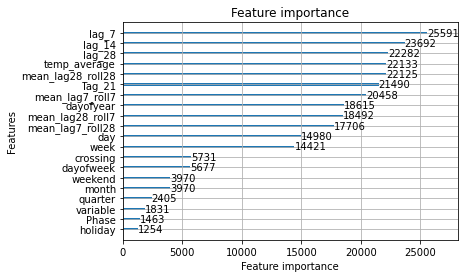

In [76]:
lgb.plot_importance(m_lgb)

In [77]:
train_roll = train_set.copy(deep=True)
try:
    for i in tqdm(range(1,500)):
        _to_pred = pred_set.loc[pred_set['datetime'] == (datetime.datetime(2020, 9, 5) + datetime.timedelta(days= i))].copy()
        _first_concat = pd.concat([train_roll, _to_pred])
        _first_concat.reset_index(inplace=True, drop=True)
        _first_concat = date_lags(_first_concat)
        _to_pred = _first_concat.loc[_first_concat['datetime'] == (datetime.datetime(2020, 9, 5) + datetime.timedelta(days= i))].copy()
        _to_pred_feats = _to_pred[train_cols]
        first_pred = m_lgb.predict(_to_pred_feats)
        _to_pred['value'] = first_pred
        train_roll = pd.concat([train_roll, _to_pred])
except:
    print('end of loop')

  7%|▋         | 35/499 [00:04<01:03,  7.25it/s]


end of loop


In [78]:
train_roll

,datetime,crossing,variable,value,month,dayofweek,year,week,day,quarter,...,holiday,temp_average,lag_7,lag_14,lag_21,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,2018-01-01,0,0,3527.000000,1,0,2018,1,1,1,...,1,34.744700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,0,1,25636.000000,1,0,2018,1,1,1,...,1,34.744700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,1,0,1876.000000,1,0,2018,1,1,1,...,1,34.744700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,1,1,11829.000000,1,0,2018,1,1,1,...,1,34.744700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,2,0,5523.000000,1,0,2018,1,1,1,...,1,34.744700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18247,2020-10-10,6,1,122778.079041,10,5,2020,41,10,4,...,0,61.682719,121257.816891,122028.120683,114854.818411,116770.029667,129435.810684,128685.642563,126648.486890,128293.836008
18248,2020-10-10,7,0,13803.239733,10,5,2020,41,10,4,...,0,61.682719,14576.437263,13429.938040,13200.869669,13359.020030,12910.232027,12263.373466,12070.778852,12807.194713
18249,2020-10-10,7,1,89817.293033,10,5,2020,41,10,4,...,0,61.682719,88785.585084,88614.183347,86278.995620,86298.274970,87747.657521,87235.828674,85913.500526,85644.517989
18250,2020-10-10,8,0,22878.658622,10,5,2020,41,10,4,...,0,61.682719,24149.659547,24321.185678,23255.793354,23177.407712,21951.882815,21349.516827,21235.810422,22744.631177


In [79]:
_lgbm_pred

NameError: name '_lgbm_pred' is not defined

In [80]:
_inverse_variable = {0: 'cash', 1: 'ezpass'}
_lgbm_pred = train_roll.loc[train_roll['datetime'].isin(pd.date_range('2020-09-06', '2020-10-10'))][['datetime', 'crossing', 'variable',  'value']]
_lgbm_pred['variable'] = [_inverse_variable[item] for item in _lgbm_pred['variable']]
_lgbm_pred['crossing'] = le.inverse_transform(_lgbm_pred['crossing'])

In [81]:
_lgbm_pred

,datetime,crossing,variable,value
17622,2020-09-06,Brooklyn Battery,cash,5454.680943
17623,2020-09-06,Brooklyn Battery,ezpass,32997.709207
17624,2020-09-06,Cross Bay,cash,3680.692469
17625,2020-09-06,Cross Bay,ezpass,18523.344030
17626,2020-09-06,Henry Hudson,cash,7503.732863
...,...,...,...,...
18247,2020-10-10,Triboro,ezpass,122778.079041
18248,2020-10-10,Verrazano,cash,13803.239733
18249,2020-10-10,Verrazano,ezpass,89817.293033
18250,2020-10-10,Whitestone,cash,22878.658622


In [82]:
_lgbm_pivot = _lgbm_pred.pivot(index='datetime', columns=['crossing', 'variable'], values='value')

In [83]:
_lgbm_pivot.columns

MultiIndex([('Brooklyn Battery',   'cash'),
            ('Brooklyn Battery', 'ezpass'),
            (       'Cross Bay',   'cash'),
            (       'Cross Bay', 'ezpass'),
            (    'Henry Hudson',   'cash'),
            (    'Henry Hudson', 'ezpass'),
            (  'Marine Parkway',   'cash'),
            (  'Marine Parkway', 'ezpass'),
            (  'Queens Midtown',   'cash'),
            (  'Queens Midtown', 'ezpass'),
            (     'Throgs Neck',   'cash'),
            (     'Throgs Neck', 'ezpass'),
            (         'Triboro',   'cash'),
            (         'Triboro', 'ezpass'),
            (       'Verrazano',   'cash'),
            (       'Verrazano', 'ezpass'),
            (      'Whitestone',   'cash'),
            (      'Whitestone', 'ezpass')],
           names=['crossing', 'variable'])

In [84]:
crossing_rates

{('Brooklyn Battery', 'cash'): 9.5,
 ('Brooklyn Battery', 'ezpass'): 6.12,
 ('Cross Bay', 'cash'): 4.75,
 ('Cross Bay', 'ezpass'): 2.29,
 ('Henry Hudson', 'cash'): 7.0,
 ('Henry Hudson', 'ezpass'): 2.8,
 ('Marine Parkway', 'cash'): 4.75,
 ('Marine Parkway', 'ezpass'): 2.29,
 ('Queens Midtown', 'cash'): 9.5,
 ('Queens Midtown', 'ezpass'): 6.12,
 ('Throgs Neck', 'cash'): 9.5,
 ('Throgs Neck', 'ezpass'): 6.12,
 ('Triboro', 'cash'): 9.5,
 ('Triboro', 'ezpass'): 6.12,
 ('Verrazano', 'cash'): 19.0,
 ('Verrazano', 'ezpass'): 12.24,
 ('Whitestone', 'cash'): 9.5,
 ('Whitestone', 'ezpass'): 6.12}

In [86]:
test_set['variable'] = np.where(test_set['variable'].eq(0), 'cash', 'ezpass')

In [88]:
test_set['crossing'] = le.inverse_transform(test_set['crossing'])

ValueError: y contains previously unseen labels: ['Brooklyn Battery' 'Cross Bay' 'Henry Hudson' 'Marine Parkway'
 'Queens Midtown' 'Throgs Neck' 'Triboro' 'Verrazano' 'Whitestone']

In [89]:
_test_pivot = test_set.pivot(index='datetime', columns = ['crossing', 'variable'], values='value')

ValueError: Index contains duplicate entries, cannot reshape

In [90]:
_test_pivot

crossing   Brooklyn Battery        Cross Bay        Henry Hudson         \
variable               cash ezpass      cash ezpass         cash ezpass   
datetime                                                                  
2020-09-06             6117  30212      5033  21712         7646  39753   
2020-09-07             5096  26185      4479  19265         7338  39943   
2020-09-08             7067  48038      3723  20921         8249  52342   
2020-09-09             7299  49254      3197  19495         7970  54056   
2020-09-10             7001  48671      2972  17770         7947  52680   
2020-09-11             8412  48466      3594  20899         9942  60717   
2020-09-12             6373  33000      3547  18167         9498  49125   
2020-09-13             5622  29947      2974  15320         6984  40328   
2020-09-14             7039  47134      3448  19321         7758  50456   
2020-09-15             7059  48456      3312  19223         8001  54097   
2020-09-16             7144  47924      3201  19159         7893  53611   
2020-09-17             7414  50449      3367  19263         8446  56802   
2020-09-18             7892  48118      3389  19678        10121  60502   
2020-09-19             6688  33910      3244  17017         9485  48963   
2020-09-20             5145  26614      2776  14633         7892  42830   
2020-09-21             6883  45178      2966  18109         8070  50502   
2020-09-22             7137  48129      3328  19380         8084  52792   
2020-09-23             7354  50102      3612  20659         8520  56115   
2020-09-24             7553  49494      3173  19502         9238  58189   
2020-09-25             8190  50476      3599  20703        10649  61564   
2020-09-26             6756  36662      3269  17050         9897  51542   
2020-09-27             5292  28346      2937  15961         8291  43456   
2020-09-28             5762  35586      3005  17535         7211  45275   
2020-09-29             6881  48250      3013  18058         7680  51968   
2020-09-30             7298  49791      3262  18869         8275  54657   
2020-10-01             7871  51671      3405  20417         8800  58247   
2020-10-02             7681  48991      3482  20210        10208  60587   
2020-10-03             7157  35244      3133  16884         9799  50638   
2020-10-04             4910  26317      2573  14302         8245  44802   
2020-10-05             6750  45939      3066  18206         7562  48787   
2020-10-06             7093  48860      3385  18802         7695  52157   
2020-10-07             7090  48514      3227  18876         8126  53803   
2020-10-08             7313  49405      3313  19392         8370  55294   
2020-10-09             7540  46132      3402  19839        10035  60207   
2020-10-10             6316  34818      3177  16757        10105  51852   

crossing   Marine Parkway        Queens Midtown        Throgs Neck         \
variable             cash ezpass           cash ezpass        cash ezpass   
datetime                                                                    
2020-09-06           5524  26312           9804  34976       21163  95740   
2020-09-07           4510  23131           9018  35091       19276  88550   
2020-09-08           3450  22074          11666  54996       16068  90434   
2020-09-09           2877  19944          11353  55885       15121  89586   
2020-09-10           2565  17930          11189  54720       14689  85469   
2020-09-11           3217  21266          13150  60236       17254  93955   
2020-09-12           3249  18416          11830  46223       19070  91079   
2020-09-13           2883  15867           9668  38228       17919  85451   
2020-09-14           3048  19650          11071  52747       14968  85243   
2020-09-15           2978  19763          11623  56283       14776  86100   
2020-09-16           2699  19577          11182  55362       14509  86537   
2020-09-17           2637  20264          12130  59576       15200  900

In [91]:
_test_dollars = 0
for i,x in crossing_rates.items():
    _test_dollars += _test_pivot[i].sum() * x

In [92]:
_test_dollars

173780402.32

In [93]:
_lgbm_dollars = 0
for i,x in crossing_rates.items():
    _lgbm_dollars += _lgbm_pivot[i].sum() * x

In [94]:
_lgbm_dollars

174656216.02237716

In [95]:
_lgbm_dollars - _test_dollars

875813.7023771703

In [203]:
_test_pivot

crossing   Brooklyn Battery        Cross Bay        Henry Hudson         \
variable               cash ezpass      cash ezpass         cash ezpass   
datetime                                                                  
2020-09-06             6117  30212      5033  21712         7646  39753   
2020-09-07             5096  26185      4479  19265         7338  39943   
2020-09-08             7067  48038      3723  20921         8249  52342   
2020-09-09             7299  49254      3197  19495         7970  54056   
2020-09-10             7001  48671      2972  17770         7947  52680   
2020-09-11             8412  48466      3594  20899         9942  60717   
2020-09-12             6373  33000      3547  18167         9498  49125   
2020-09-13             5622  29947      2974  15320         6984  40328   
2020-09-14             7039  47134      3448  19321         7758  50456   
2020-09-15             7059  48456      3312  19223         8001  54097   
2020-09-16             7144  47924      3201  19159         7893  53611   
2020-09-17             7414  50449      3367  19263         8446  56802   
2020-09-18             7892  48118      3389  19678        10121  60502   
2020-09-19             6688  33910      3244  17017         9485  48963   
2020-09-20             5145  26614      2776  14633         7892  42830   
2020-09-21             6883  45178      2966  18109         8070  50502   
2020-09-22             7137  48129      3328  19380         8084  52792   
2020-09-23             7354  50102      3612  20659         8520  56115   
2020-09-24             7553  49494      3173  19502         9238  58189   
2020-09-25             8190  50476      3599  20703        10649  61564   
2020-09-26             6756  36662      3269  17050         9897  51542   
2020-09-27             5292  28346      2937  15961         8291  43456   
2020-09-28             5762  35586      3005  17535         7211  45275   
2020-09-29             6881  48250      3013  18058         7680  51968   
2020-09-30             7298  49791      3262  18869         8275  54657   
2020-10-01             7871  51671      3405  20417         8800  58247   
2020-10-02             7681  48991      3482  20210        10208  60587   
2020-10-03             7157  35244      3133  16884         9799  50638   
2020-10-04             4910  26317      2573  14302         8245  44802   
2020-10-05             6750  45939      3066  18206         7562  48787   
2020-10-06             7093  48860      3385  18802         7695  52157   
2020-10-07             7090  48514      3227  18876         8126  53803   
2020-10-08             7313  49405      3313  19392         8370  55294   
2020-10-09             7540  46132      3402  19839        10035  60207   
2020-10-10             6316  34818      3177  16757        10105  51852   

crossing   Marine Parkway        Queens Midtown        Throgs Neck         \
variable             cash ezpass           cash ezpass        cash ezpass   
datetime                                                                    
2020-09-06           5524  26312           9804  34976       21163  95740   
2020-09-07           4510  23131           9018  35091       19276  88550   
2020-09-08           3450  22074          11666  54996       16068  90434   
2020-09-09           2877  19944          11353  55885       15121  89586   
2020-09-10           2565  17930          11189  54720       14689  85469   
2020-09-11           3217  21266          13150  60236       17254  93955   
2020-09-12           3249  18416          11830  46223       19070  91079   
2020-09-13           2883  15867           9668  38228       17919  85451   
2020-09-14           3048  19650          11071  52747       14968  85243   
2020-09-15           2978  19763          11623  56283       14776  86100   
2020-09-16           2699  19577          11182  55362       14509  86537   
2020-09-17           2637  20264          12130  59576       15200  900

In [99]:
for i in crossing_rates.keys():
    print(i, _lgbm_pivot[i].sum() - _test_pivot[i].sum())

('Brooklyn Battery', 'cash') -278.1550693587924
('Brooklyn Battery', 'ezpass') 74889.09317507315
('Cross Bay', 'cash') 126.90463040419854
('Cross Bay', 'ezpass') 23522.4257764169
('Henry Hudson', 'cash') -3325.0628475947306
('Henry Hudson', 'ezpass') -31781.3404686898
('Marine Parkway', 'cash') 5941.925150502881
('Marine Parkway', 'ezpass') 26475.470203319914
('Queens Midtown', 'cash') 607.524824435648
('Queens Midtown', 'ezpass') 596.3616537856869
('Throgs Neck', 'cash') -385.5392971652327
('Throgs Neck', 'ezpass') 149710.80463140272
('Triboro', 'cash') -60270.825235487544
('Triboro', 'ezpass') -98093.35787317995
('Verrazano', 'cash') -6321.615199856227
('Verrazano', 'ezpass') 84772.03666504938
('Whitestone', 'cash') -51720.251696567284
('Whitestone', 'ezpass') 34940.329440886155


In [96]:
_lgbm_pivot

crossing   Brooklyn Battery                  Cross Bay                \
variable               cash        ezpass         cash        ezpass   
datetime                                                               
2020-09-06      5454.680943  32997.709207  3680.692469  18523.344030   
2020-09-07      6223.981604  35318.445069  3329.024885  17074.582759   
2020-09-08      6501.302970  48128.716720  3380.616174  19829.689753   
2020-09-09      6809.957377  49696.574051  3099.646810  18843.321415   
2020-09-10      7516.061394  51109.991205  2936.140962  19867.977494   
2020-09-11      7727.360240  48178.950695  4203.938153  22389.944097   
2020-09-12      6129.958220  32649.423783  3531.548540  18211.635436   
2020-09-13      5864.519716  35255.725676  3430.756220  17941.465795   
2020-09-14      6793.070772  47646.943567  3561.070098  18850.166418   
2020-09-15      6890.997154  50069.093836  3583.585243  20053.824752   
2020-09-16      6854.773326  51195.781413  3650.534890  18969.492728   
2020-09-17      7730.888971  51927.319990  3538.131593  20558.957360   
2020-09-18      7811.671637  50080.978672  3702.767648  22460.487164   
2020-09-19      6327.601817  34993.438815  3434.752845  18653.736856   
2020-09-20      5571.434511  37610.889415  3279.168497  17664.484258   
2020-09-21      6124.663319  44623.219632  3069.885489  18193.352958   
2020-09-22      6653.956700  48209.934144  3147.143378  19847.851001   
2020-09-23      6965.373087  49595.670264  3188.144594  19354.362076   
2020-09-24      7449.179741  49106.122346  3303.116870  19821.534026   
2020-09-25      7965.811374  49775.801293  3312.479210  21993.344002   
2020-09-26      6342.230987  38897.621322  3288.371084  18595.129235   
2020-09-27      5886.208093  37654.622436  3137.635095  17437.384821   
2020-09-28      7136.219979  44001.596289  3174.691103  18193.751698   
2020-09-29      7068.538955  45234.144828  3265.825556  19162.267497   
2020-09-30      7050.820072  44025.430168  3305.885575  18816.330291   
2020-10-01      7902.330296  46614.595789  3084.607318  18968.954860   
2020-10-02      8580.891175  48432.542237  3681.056451  20976.849681   
2020-10-03      7103.609087  37877.502764  3144.134966  18747.708059   
2020-10-04      6272.375680  36432.147371  2998.448066  18133.241503   
2020-10-05      6423.358805  47504.596820  3288.778145  18015.644251   
2020-10-06      6388.133154  50865.339706  3188.718019  19911.434988   
2020-10-07      6186.929352  47987.726696  3111.213906  18852.208153   
2020-10-08      7470.646892  51346.287454  3175.609781  19669.626595   
2020-10-09      8022.586384  50453.897319  3353.211124  21661.646345   
2020-10-10      6714.721149  43673.312187  3148.573872  18630.693422   

crossing    Henry Hudson               Marine Parkway                \
variable            cash        ezpass           cash        ezpass   
datetime                                                              
2020-09-06   7503.732863  45844.808199    3989.244565  20773.010355   
2020-09-07   7195.080270  39438.236165    2697.238382  17795.552190   
2020-09-08   7527.774634  53079.982308    2790.567237  20114.430200   
2020-09-09   7832.174385  55122.900897    2819.372473  18598.761359   
2020-09-10   8460.807649  57561.020782    2660.363026  20124.412769   
2020-09-11   9584.599689  59599.113347    3603.194575  22014.491540   
2020-09-12   8944.382385  46419.574095    3280.759266  18302.761608   
2020-09-13   7440.196066  46190.157533    3068.927287  18725.581811   
2020-09-14   7521.328810  52746.701271    2875.482081  19617.159696   
2020-09-15   7544.651769  55764.662309    3027.651064  20677.374369   
2020-09-16   7832.755952  56126.651000    2852.085789  19361.152352   
2020-09-17   8444.680863  59015.968511    3022.860181  21136.729642   
2020-09-18   9769.006479  58595.970492    3560.193698  22399.943297   
2020-09-19   9078.354741  45124.176977    3204.786205  18895.658510   
2020-09-20   7750.938496  42860.842525    3134.774707  1

In [209]:
_lgbm_rmse = []
_lgbm_summation = 0
for i in crossing_rates.keys():
    _lgbm_rmse.append(np.sqrt(mean_squared_error(_test_pivot[i], _lgbm_pivot[i])))

In [212]:
sum(_lgbm_rmse)

47293.25055768396

In [216]:
_lgbm_pred = train_roll.loc[train_roll['datetime'].isin(pd.date_range('2020-09-06', '2020-10-10'))][['datetime', 'crossing', 'variable',  'value']]
# _lgbm_pred
_lgbm_pred['crossing'] = le.inverse_transform(_lgbm_pred['crossing'])
_lgbm_pivot_pred = _lgbm_pred.pivot(index='datetime', columns='crossing', values='value')
test_set_pivot = test_set.pivot(index='datetime', columns = 'crossing', values='value')
test_set_pivot.columns = bridges

ValueError: Index contains duplicate entries, cannot reshape

In [128]:
_lgbm_pivot_pred

crossing,Brooklyn Battery_cash,Brooklyn Battery_ezpass,Cross Bay_cash,Cross Bay_ezpass,Henry Hudson_cash,Henry Hudson_ezpass,Marine Parkway_cash,Marine Parkway_ezpass,Queens Midtown_cash,Queens Midtown_ezpass,Throgs Neck_cash,Throgs Neck_ezpass,Triboro_cash,Triboro_ezpass,Verrazano_cash,Verrazano_ezpass,Whitestone_cash,Whitestone_ezpass
datetime,,,,,,,,,,,,,,,,,,
2020-09-06,5961.508733,35846.876225,3442.123603,18309.174085,8234.272315,47161.604531,3707.859061,20744.994471,10810.826693,45040.149900,19264.226951,99099.077761,28180.716982,121742.104201,12688.895485,82485.490471,22430.401637,105268.225308
2020-09-07,6444.277694,34127.478609,3165.422260,17321.356970,7054.248891,38298.879373,2558.150080,17758.875143,10738.001487,40547.387660,16145.376942,84009.819884,24702.880006,121289.241440,11355.511213,76322.090183,19424.449950,95190.455209
2020-09-08,6590.742174,47641.386546,3390.317046,19693.640532,7288.303421,51611.143431,2734.960423,19554.965803,11145.834033,55817.950679,15222.845376,90370.032110,24800.048883,135550.867676,11078.306872,88407.870574,19131.853928,99588.915982
2020-09-09,6605.371308,48514.947374,3152.800282,18931.829163,7650.778672,54868.751478,2886.204010,18799.017402,11151.775475,56357.572073,14899.216115,90778.457415,24976.274721,132961.750668,10932.148055,87111.934439,18828.264820,101493.911015
2020-09-10,7325.171364,49042.480607,3012.425355,19275.342588,8648.111550,56108.275633,2904.127973,19154.942084,11588.165063,58543.380058,15513.097222,93884.693263,26131.104722,141148.906650,11430.707190,91642.986966,20564.258002,107766.504732
2020-09-11,7534.105568,46091.456970,3741.458648,21775.017080,9715.315941,59386.086643,3193.803468,21972.004351,12665.684859,57875.322248,17058.575939,96697.641732,26744.694216,149349.961015,12739.433299,91514.992390,22667.129852,113773.738924
2020-09-12,6384.642438,34128.000895,3777.434691,19372.058532,9672.498041,47808.248076,3647.542775,20438.412592,11570.582781,42393.423432,19846.187492,94542.621469,28651.996748,122055.769888,14109.185689,84271.525098,23179.496130,102465.951304
2020-09-13,5730.016044,35461.033942,3100.872953,16482.849591,8092.743128,47137.187538,2717.331833,17121.219324,10956.831573,46084.857115,18261.697229,93779.478651,25044.122090,117801.306842,12680.563033,81256.414735,21435.846285,106056.685547
2020-09-14,6748.726652,43930.948069,3453.070765,19035.099994,7285.959783,52793.321701,3113.823613,19337.681477,10994.056288,51346.806790,15469.403521,91617.775899,24480.931187,133571.600770,11249.619940,83859.504217,19462.107307,102810.521437


In [131]:
_lgbm_dollars = 0
for crossing,rate in tqdm(crossing_rates.items()):
    _lgbm_dollars += _lgbm_pivot_pred[crossing].sum() * rate

100%|██████████| 18/18 [00:00<00:00, 5999.48it/s]


In [132]:
_lgbm_dollars - _total_dollars

1172484.7978298068

In [82]:
_lgbm_rmse = []
for i in bridges:
    _lgbm_rmse.append(np.sqrt(mean_squared_error(test_set_pivot[i], _lgbm_pivot_pred[i])))
_results_df['LGBM'] = _lgbm_rmse
display(_results_df.sum(axis=0))
_results_df

bridges         Brooklyn Battery_cashBrooklyn Battery_ezpassCr...
dummy_MA7                                                 74391.5
SARIMAX                                                   45896.3
FB_prophet_1                                              40939.4
LGBM                                                      46283.2
dtype: object

,bridges,dummy_MA7,SARIMAX,FB_prophet_1,LGBM
0,Brooklyn Battery_cash,897.963817,612.227203,618.120912,553.232739
1,Brooklyn Battery_ezpass,8555.505708,3230.593207,3355.836134,4072.185416
2,Cross Bay_cash,799.763228,552.047553,416.696658,406.114840
3,Cross Bay_ezpass,2891.665227,1760.772889,1380.337438,1285.584629
4,Henry Hudson_cash,1033.794866,615.152942,739.011878,586.071300
5,Henry Hudson_ezpass,6001.858192,4011.601010,2926.605642,3154.198591
6,Marine Parkway_cash,1211.033429,980.635087,587.413843,546.723609
7,Marine Parkway_ezpass,4535.955593,3085.176388,2518.548791,2043.620207
8,Queens Midtown_cash,1186.325490,1090.033137,1342.400382,844.472289
9,Queens Midtown_ezpass,8093.426751,5363.611894,5905.471540,3985.013492


In [83]:
_results_df.sum(axis=0)

bridges         Brooklyn Battery_cashBrooklyn Battery_ezpassCr...
dummy_MA7                                                 74391.5
SARIMAX                                                   45896.3
FB_prophet_1                                              40939.4
LGBM                                                      46283.2
dtype: object

# Best Model Forward: SARIMAX
LGBM previously performed the best out of the three.... things have changed but I will forecast using LGBM. <br>
LGBM performed the best out of the three. On the next notebook, I will refit the model off the entire dataset and predict up to March-31-2021. <br>
In addition, I'll change some of the phases on January-1-2021:
1. Phase -1: Coronavirus is over, return back to normal
2. Phase 4: Continue with Phase 4
3. Phase 1: Lockdown and reopen on February-01-2021